# **AI: Machine Learning**

<img src="https://emojigraph.org/media/apple/robot_1f916.png" alt="logo" width="128">


## **Jason Monroe**

<p> ✉️ <a href="mailto:jason@jasonmonroe.com?subject=GitHub Machine Learning Customer Review Classification & Summarization">jason@jasonmonroe.com</a></p>

<p>📅 November 21, 2024</p>


<p>🗂️ banking_churn_predictor_notebook.html</p>

---

# **Introduction to Neural Networks: Bank Churn Prediction**

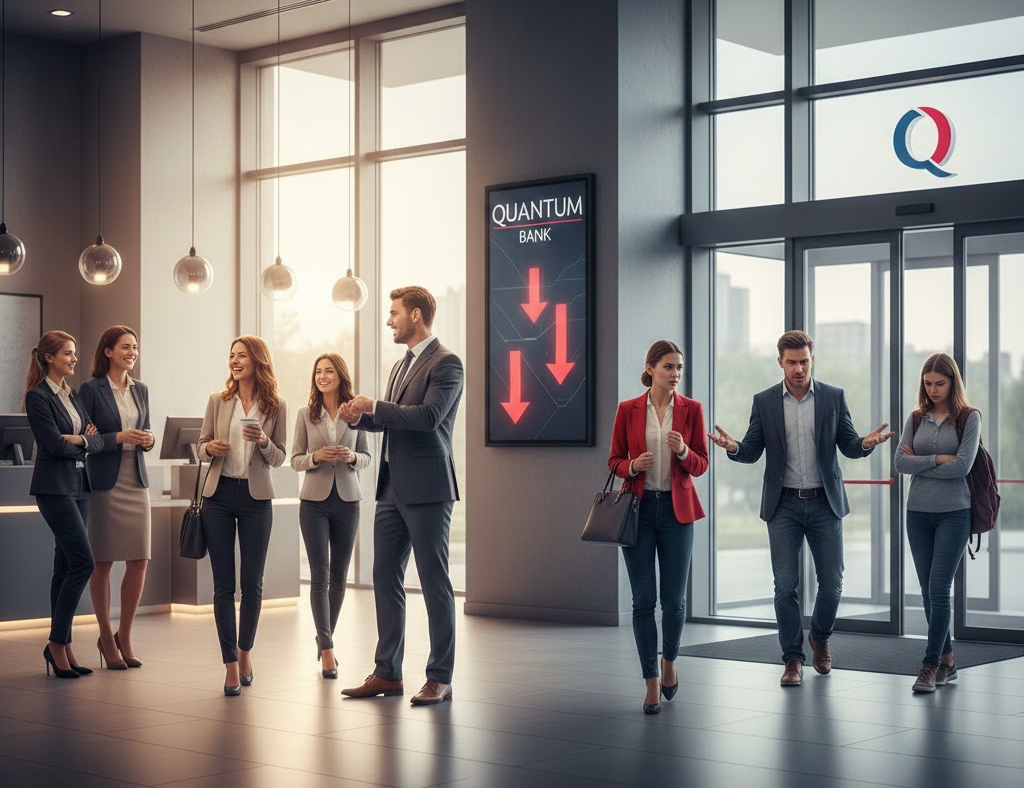

## Problem Statement

### Context

In service industries, particularly banking, mitigating customer churn is a critical business imperative. Understanding the factors contributing to customer attrition is essential for sustained profitability. We propose developing a Machine Learning model to rigorously quantify the feature importance of various service attributes (e.g., transaction speed, fee structures, customer support quality) on a customer's likelihood to terminate their service agreement. The resulting prioritized list of influential factors will guide management in making data-driven decisions to refine the service offering and optimize retention strategies.

### Objective

*As a Data Scientist, you are tasked with architecting and implementing a Deep Learning model—specifically a Neural Network—for binary classification. This model must utilize historical customer data to generate a probability score indicating the likelihood of an individual customer terminating their service agreement with the bank within the upcoming half-year period.*

### Data Dictionary

* customer_id: Unique ID which is assigned to each customer

* surname: Last name of the customer

* credit_score: It defines the credit history of the customer.
  
* geography: A customer’s location
   
* gender: It defines the Gender of the customer
   
* age: Age of the customer
    
* tenure: Number of years for which the customer has been with the bank

* num_of_products: refers to the number of products that a customer has purchased through the bank.

* balance: Account balance

* has_cr_card: It is a categorical variable which decides whether the customer has credit card or not.

* estimated_salary: Estimated salary

* is_active_member: It is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* exited: whether or not the customer left the bank within six month. It can take two values:
  * 0=No ( Customer did not leave the bank )
  * 1=Yes ( Customer left the bank )


## Importing necessary libraries

In [ ]:
# ==================================
#  IMPORT LIBRARIES
# ==================================

# Standard libraries
import copy
import os
import sys
import time
from typing import Union

# Vendor libraries
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Imbalanced-learn
from imblearn.over_sampling import SMOTE  # To handle class imbalance

# Scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    explained_variance_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
)

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Local Libraries


In [ ]:
import warnings  # To suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
# ==================================
#  CONSTANTS
# ==================================

FILE_NAME = 'sample_data.csv'
SOURCE_PATH = ''
CSV_FILE = SOURCE_PATH + FILE_NAME

BALANCE_THRESHOLD = 20000 # In $ (dollars)
BATCH_CNT = 32
DROPOUT_RATE = 0.25
DROPOUT_SMOTE_RATE = 0.3
EPOCH_CNT = 100
LEARNING_RATE = 0.001
NEURON_CNT = 64
DEFAULT_NEURON_CNT = 32
SECS_IN_MIN = 60
SEED = 42 # Hard coded Seed value for random state

# Splitting data
# Original Data = 100%
# First split = Temp 80%, 20% Test
TEMP_SPLIT = 0.80
TESTING_SPLIT = 0.20

# Second split = (Temp): 75% Training, 25% validation
TRAINING_SPLIT = 0.75
VALIDATION_SPLIT = 0.25 # 25% of 80% ~ 20%

In [ ]:
# ==================================
#  HELPER FUNCTIONS
# ==================================

def start_timer() -> float:
    """
    Start a timer
    """
    return time.time()


def get_time(start_time_float: float) -> str:
    diff = abs(time.time() - start_time_float)
    hours, remainder = divmod(diff, SECS_IN_MIN*SECS_IN_MIN)
    minutes, seconds = divmod(remainder, SECS_IN_MIN)
    fractional_seconds = seconds - int(seconds)

    ms = fractional_seconds * 1000
    return f"{int(minutes)}m {int(seconds)}s {int(ms)}ms"


def show_timer(start_time_int: float) -> None:
    print(f"Run Time: {get_time(start_time_int)}")


def show_banner(title: str, section: str='') -> None:
    padding = 2
    strlen = len(title) + padding

    # Top line
    print("\n")
    print('# ', end='')
    print('=' * strlen)
    print('#', end='')

    # Show title
    print('  ' + title)

    print('# ', end='')
    print('=' * strlen)
    print('#', end='')

    # Show section
    if section:
        print(' ' + section)
        print("\n")

## Loading the dataset

In [ ]:
# Load data
data = pd.read_csv(CSV_FILE)

In [ ]:
# Get file path
#if sys.modules.get('google.colab'):
#    CONTENT_PATH = '/content/drive/'
#    CSV_FILE = CONTENT_PATH + FILE_NAME
#
#    drive.mount(CONTENT_PATH)
#else:
#  SOURCE_PATH = ''
#  CSV_FILE = FILE_NAME

## Data Overview

In [ ]:
# Let's view the first 5 rows of the data
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# Let's view the last 5 rows of the data
data.tail()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [ ]:
# Checking the number of rows and columns in the data
data.shape

(10000, 14)

Data consist of 14 columns with 10,000 rows.

In [ ]:
# checking datatyapes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# Describe the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
row_number,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
num_of_products,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
has_cr_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
is_active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


**Data Observations**


*   The mean credit score is 650.
*   Each customer's credit score is roughly 96 points from one another.
*   The lowest credit score is 350 (which is just 50 points from absolute minimum).
* The mean age for a customer is 38.
* The lowest balance is $11.58.  One can expect this customer has left the company?
* Customer usage of products is lower than average.




In [ ]:
# Find any missing values
data.isnull().sum()

,0
row_number,0
customer_id,0
surname,0
credit_score,0
geography,0
gender,0
age,0
tenure,0
balance,0
num_of_products,0


There are no missing values in the dataset.

In [ ]:
# Checking the dtypes of the variables in the data
data.dtypes

,0
row_number,int64
customer_id,int64
surname,object
credit_score,int64
geography,object
gender,object
age,int64
tenure,int64
balance,float64
num_of_products,int64


## Exploratory Data Analysis

### Univariate Analysis

In [ ]:
# Perform Univariate Analysis by creating boxplots, historgrams, density plots for each column.

# Define labeled barplot.
def labeled_barplot(data: pd.DataFrame, feature:str, perc:bool=False, n=None) -> None:
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count
    n: displays the top n category levels
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()

    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )
        else:
            label = p.get_height()
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )

    plt.show()  # to avoid overlap

In [ ]:
# Define a histogram boxplot
def histogram_boxplot(data: pd.DataFrame, feature: str, figsize: tuple=(12, 7), kde: bool=False, bins=None) -> None:
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,  # creating
    )

    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )

    # boxplot will be created and a star will indicate the mean value
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )

    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )

    # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )

    # Add median to the histogram
    plt.show()

In [ ]:
# Define stacked barplot
def stacked_barplot(data: pd.DataFrame, predictor: str, target: str) -> None:
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )

    print(tab1)
    print("-" * 120)

    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )

    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )

    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

Credit Score

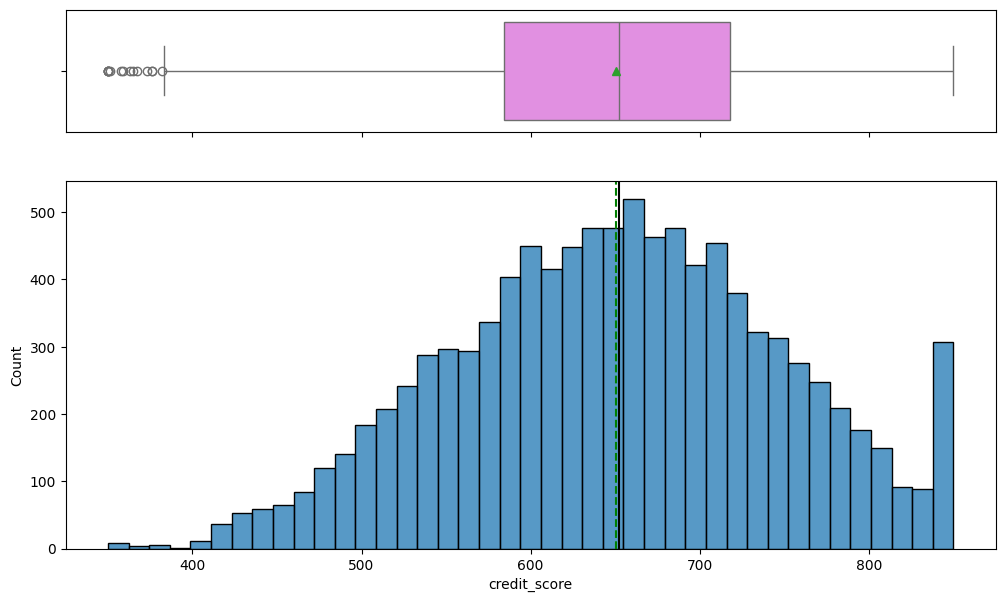

In [ ]:
# Display histogram
histogram_boxplot(data, 'credit_score')

Credit Score Observations


*   Very few customers are in the 300s.
*   Most of the customers are in the 600s which is expected.



Geography

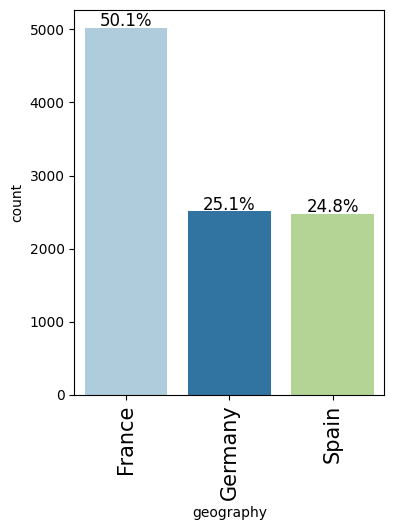

In [ ]:
# Display Geography barplot
labeled_barplot(data, 'geography', perc=True)

Geography Observations


*   Most customers are French while there are similar amount of customers from Germany and Spain.
*   Germany has a larger population than Spain yet the amount of customers is almost equal.



Gender

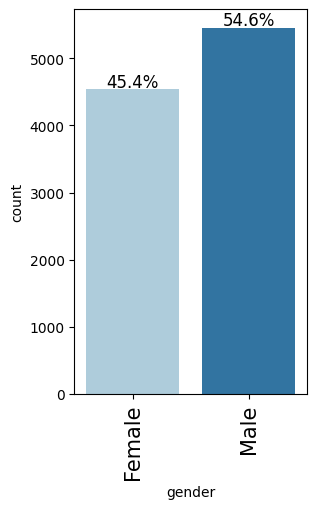

In [ ]:
# Display Gender barplot
labeled_barplot(data, 'gender', perc=True)

Gender Observations


*   There are more male customers than female.
*   There are no gender non-comformity customers.



Age

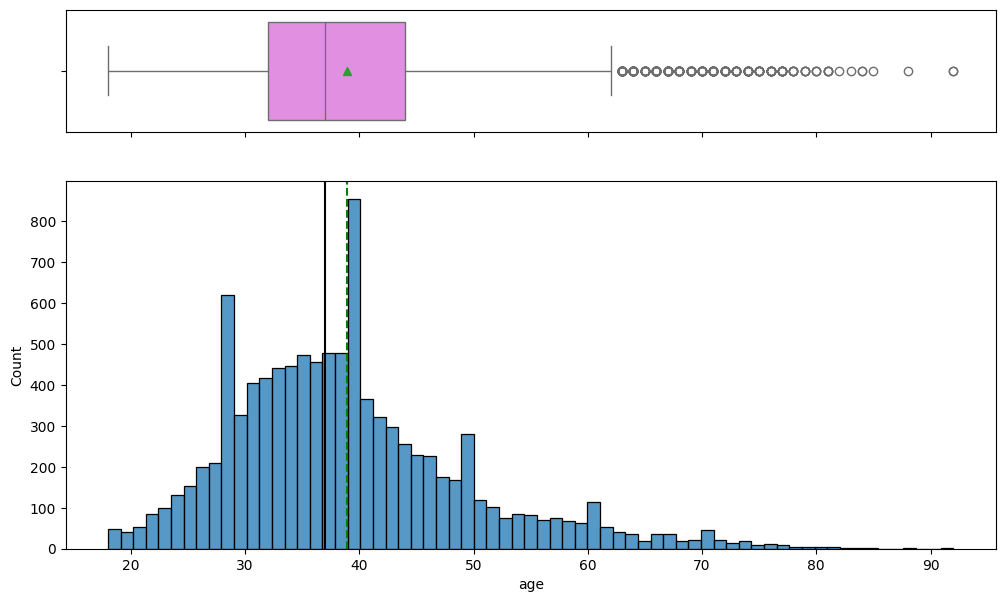

In [ ]:
# Display age histogram
histogram_boxplot(data, 'age')

Age Observations

* Age of customer drops after 52. Any age after that has little usage in the company.
* The majority of the customers are in their late 30s.



Tenure

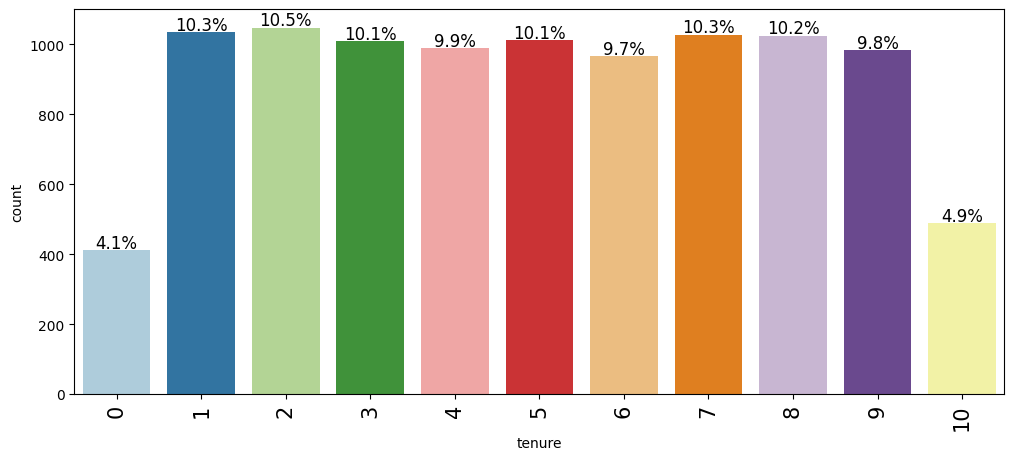

In [ ]:
# Display tenure barplot
labeled_barplot(data, 'tenure', perc=True)

Tenure Observations


*   New customers are only 4% of the customer base.
*   Second least are people who've been customers for 10 years (or more).
* Customer distribution is pretty even between 1 and 9 years.



Number of Products

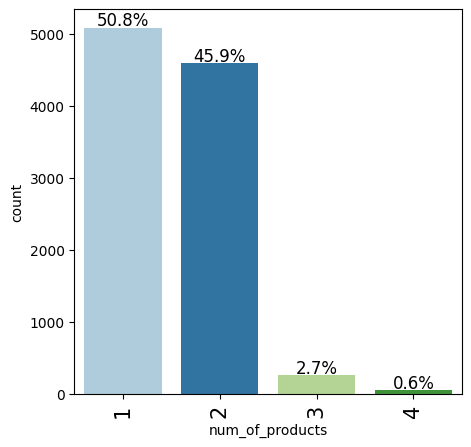

In [ ]:
# Display number of products barplot
labeled_barplot(data, 'num_of_products', perc=True)

Product Quantity Observations


*   Most of the customers use 1 to 2 products.
*   Very few customers regardless of any factor uses more than 2 products.



Balance

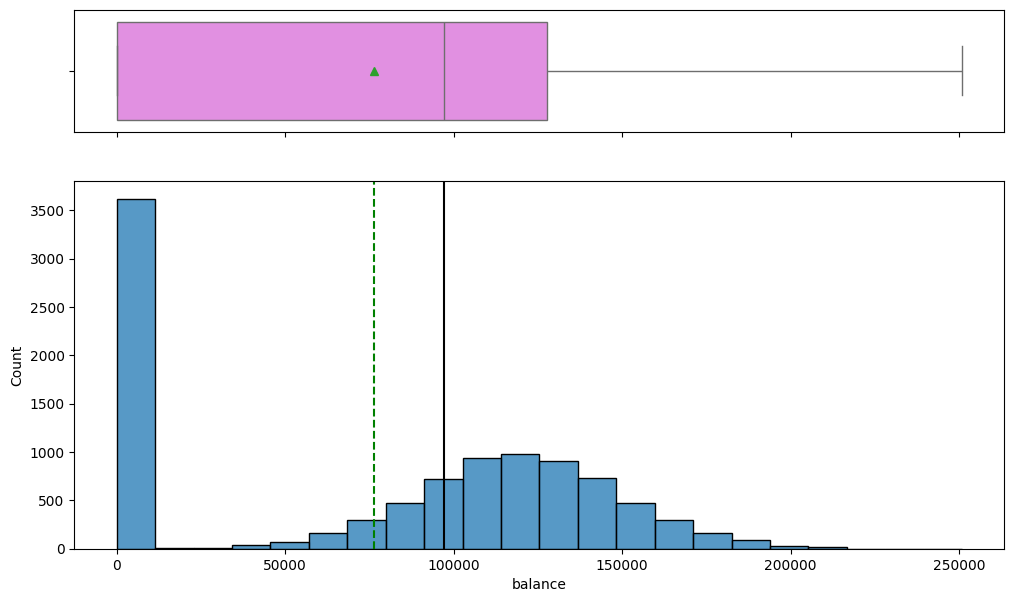

In [ ]:
# Display balance barplot
histogram_boxplot(data, 'balance')

Balance Observations

*   Just over a third of all customers have less than a balance of 10,000.
*   Second highest group are people who have a balance around 120,000.
*   No one has more than $250,000 in the bank most likely because the FDIC only ensures up to that point.



Has a credit card

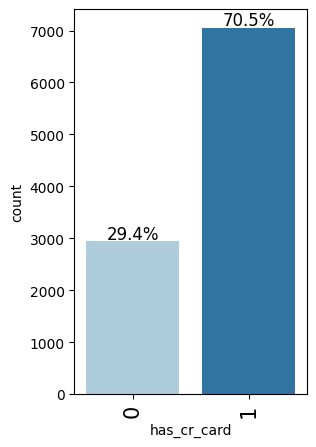

In [ ]:
# Display has a credit card barplot
labeled_barplot(data, 'has_cr_card', perc=True)

Credit Card Usage Observations


*   Over two-thirds of customers posses a credit card.
*   Just under a third do not.



Estimated Salary

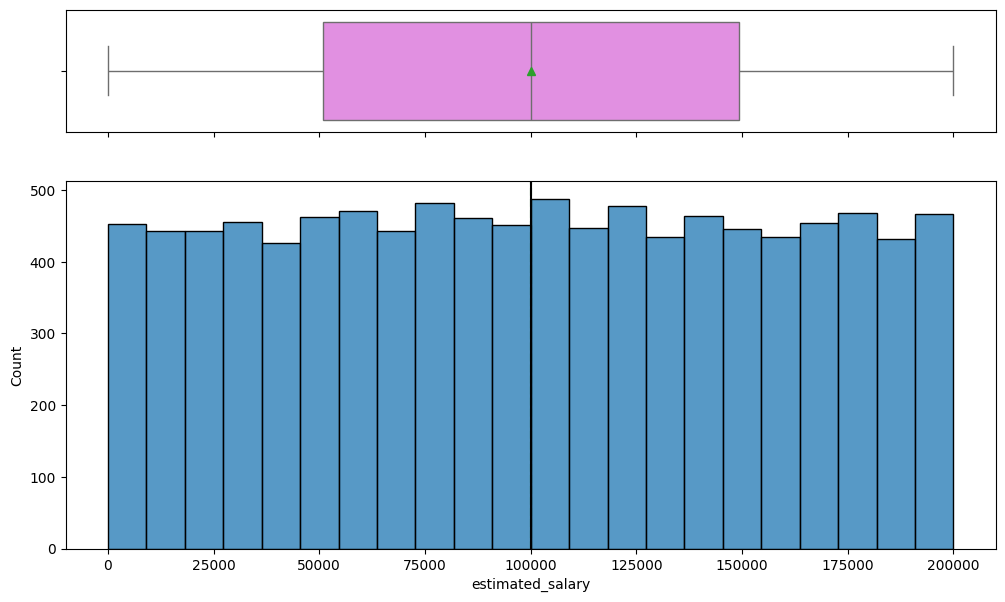

In [ ]:
# Display estimated salary boxplot
histogram_boxplot(data, 'estimated_salary')

Salary Observations

*   Sample size of salaries looks evenly distributed.



Is an active member of the bank

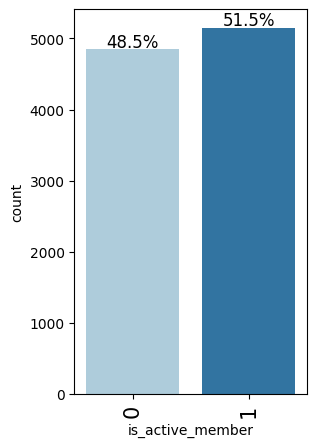

In [ ]:
# Display whether they're an active member of the bank barplot
labeled_barplot(data, 'is_active_member', perc=True)

Active Member Observations


*   Wow, half the customers are no longer active with the company.
*   Retention is barely over 50% this bank needs a better marketing department!



Customers that have left the bank (or not)

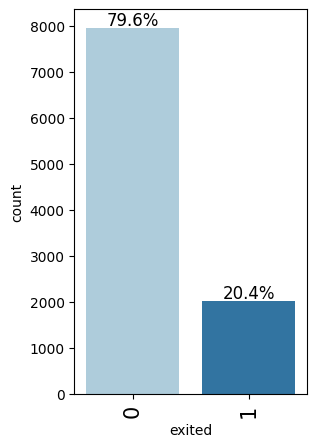

In [ ]:
# Display exited barplot
labeled_barplot(data, 'exited', perc=True)

Customer Attainment Observations


*   Almost 80% of the customers have quit doing business.
*   Only a fifth of the comapny is active.
* This is not a suprise considering that just under half the customers are inactive.



### Bivariate Analysis

In [ ]:
# Plot distributions
def distribution_plot_wrt_target(data: pd.DataFrame, predictor: str, target: str) -> None:

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [ ]:
# Compare estimated salary to bank balance to see if there's a correlation.

# Note: Group the balance by $20,000s to lower the amount of values on the x-axis
barplot_data = data.copy()
barplot_data["estimated_salary"] = barplot_data["estimated_salary"].apply(lambda x: x // BALANCE_THRESHOLD)
barplot_data["balance"] = barplot_data["balance"].apply(lambda x: x // BALANCE_THRESHOLD)

balance            0.0  1.0  2.0  3.0  4.0   5.0   6.0  7.0  8.0  9.0  10.0  \
estimated_salary                                                              
4.0                391    3   11   34   96   159   158   96   43    8     2   
All               3621   25  126  430  999  1618  1632  966  423  126    30   
0.0                395    3   10   37   98   152   148   86   42   12     3   
2.0                369    2   18   38   86   156   175  100   43   16     3   
1.0                336    2    7   51   99   173   145   93   53   10     0   
5.0                364    3   19   43  110   166   155  106   40   16     4   
3.0                347    1   18   53  112   152   189   96   39   15     5   
6.0                353    0    9   45  107   175   163   98   39   14     4   
7.0                360    2    6   48   88   159   164   90   53    6     5   
8.0                359    7   10   44   93   163   177  102   37   14     2   
9.0                347    2   18   37  110   163   1

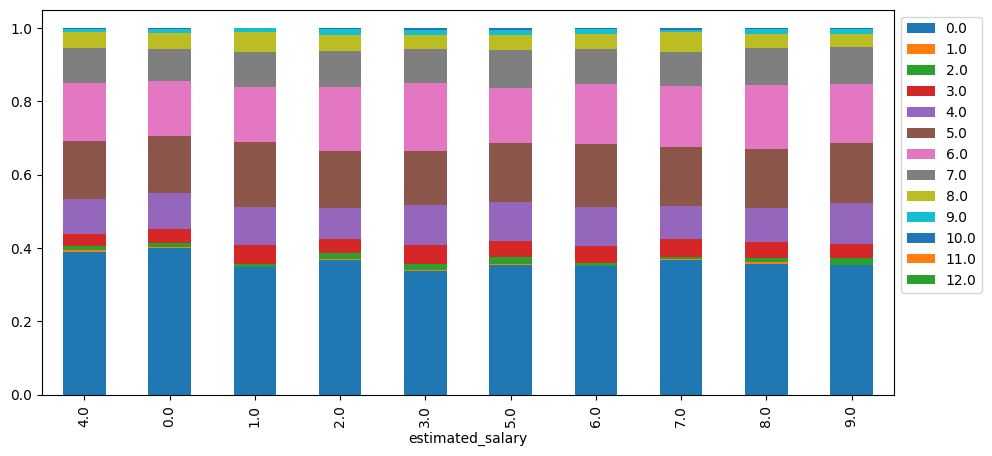

In [ ]:
# Call stacked barplot with the modified DataFrame
stacked_barplot(barplot_data, 'estimated_salary', 'balance')

del barplot_data

Observations


*   Strangly the distribution of estimated salary and bank balance is even.
*   Customers with higher income are *not* overrepresented in the high balance category.



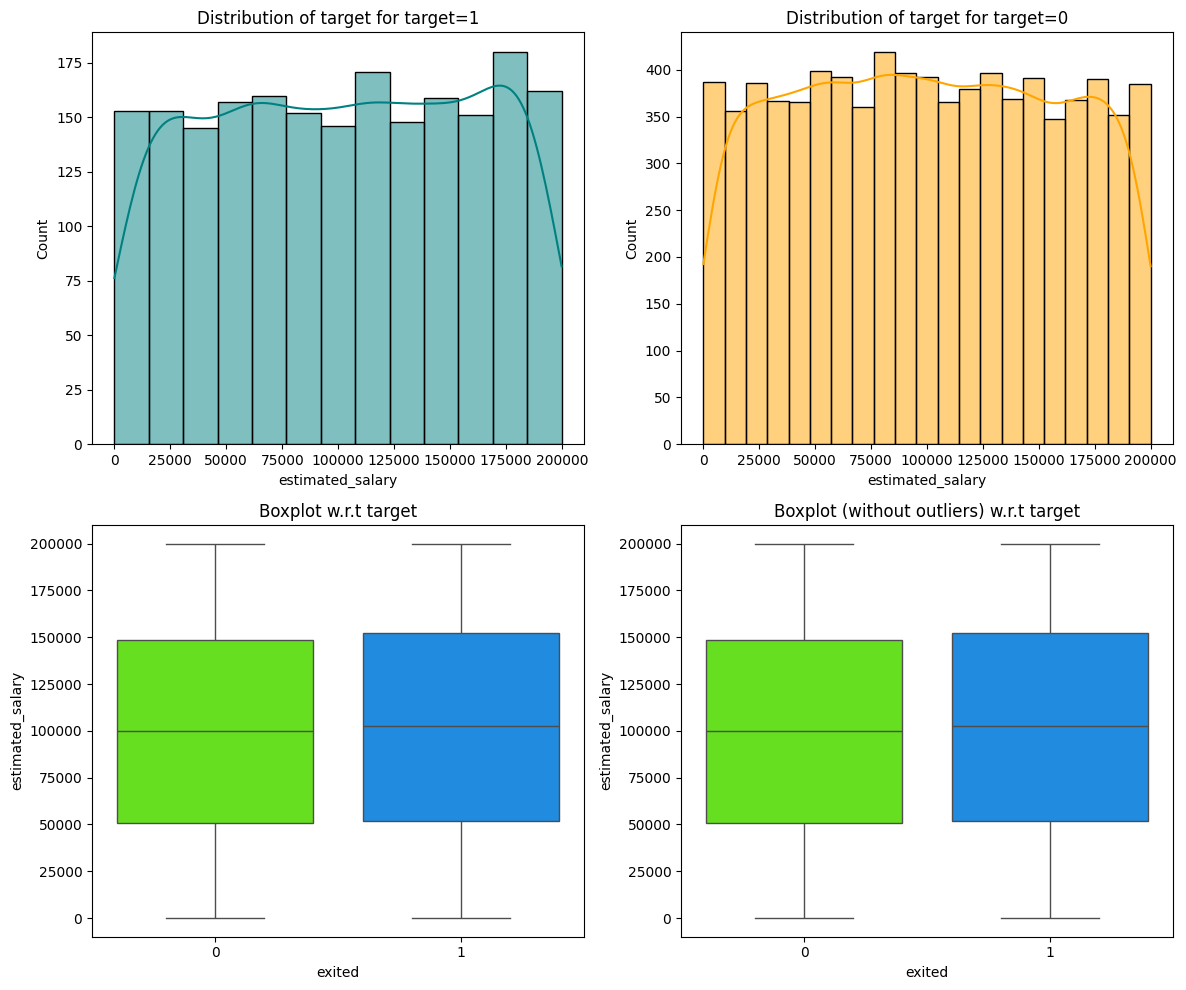

In [ ]:
# Create heatmaps to compare two columns: scatterplots, correlation coefficients, cross-tabulation, pairplot, etc
distribution_plot_wrt_target(data, 'estimated_salary', 'exited')

Observations


*   The estimated salaries are negligable for exited and non-existed customers.
*   The counts seem about even as well so estimated salary had no correlation for a customer quitting.



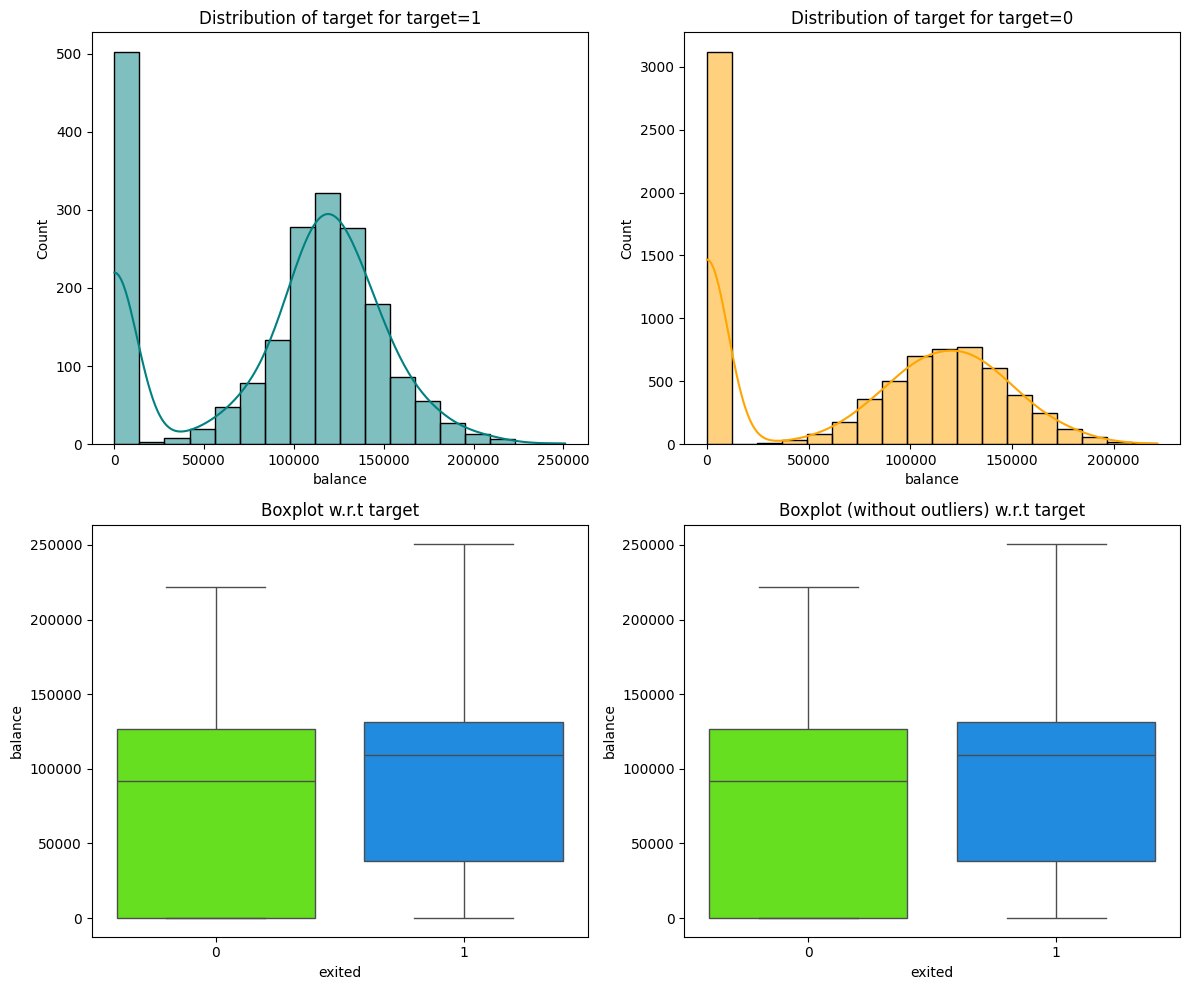

In [ ]:
# Compare bank account balance to whether they exited
distribution_plot_wrt_target(data, 'balance', 'exited')

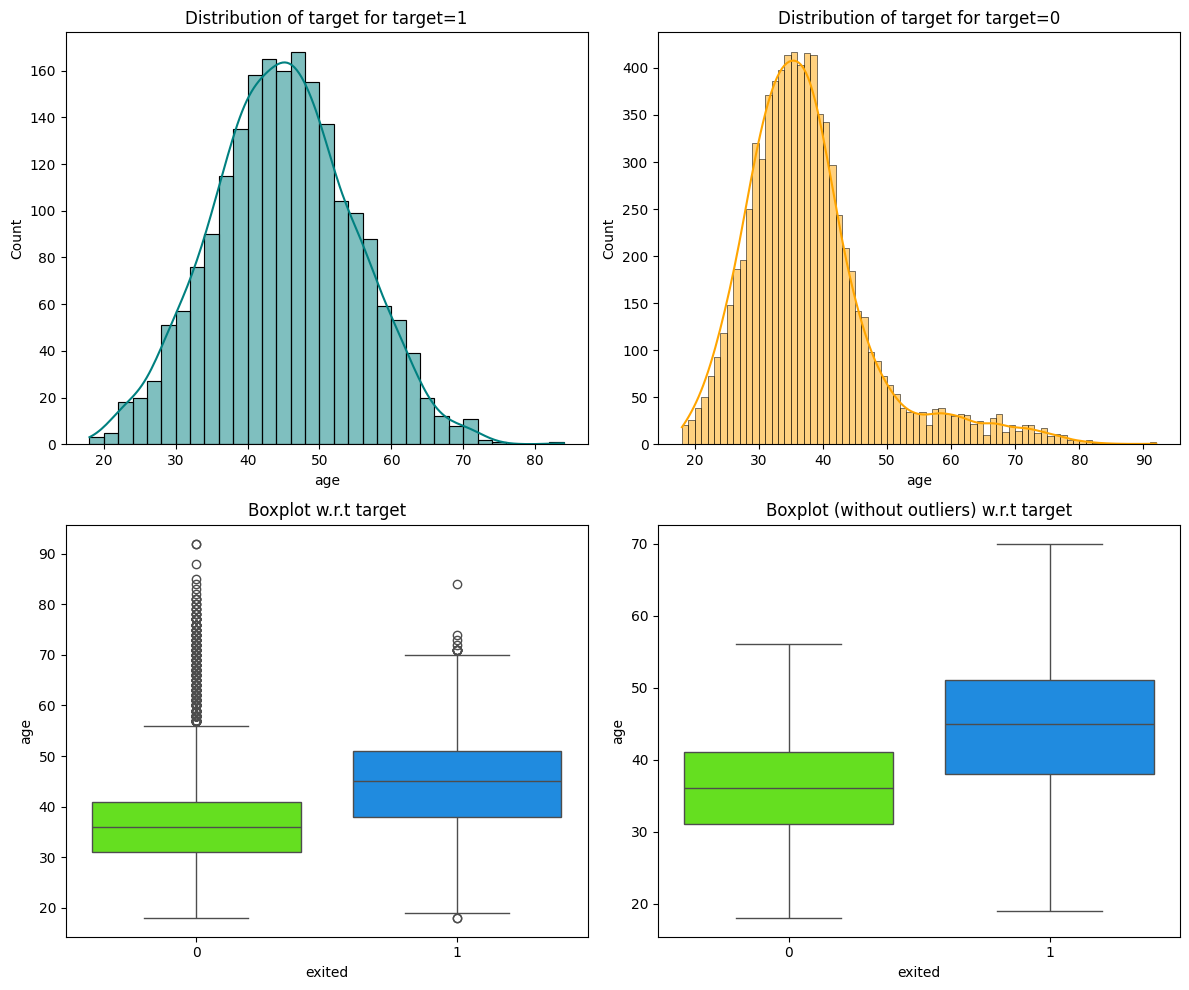

In [ ]:
# Compare age of customer to whether they exited
distribution_plot_wrt_target(data, 'age', 'exited')

Observation


*   Again, the mean age is late 30s early 40s
*   Very few customers over 70
* More customers plus 50 are exiting the company than staying.
* The ederly are outliers and outside the average when leaving.
* The older you are the more likely you are to leave.



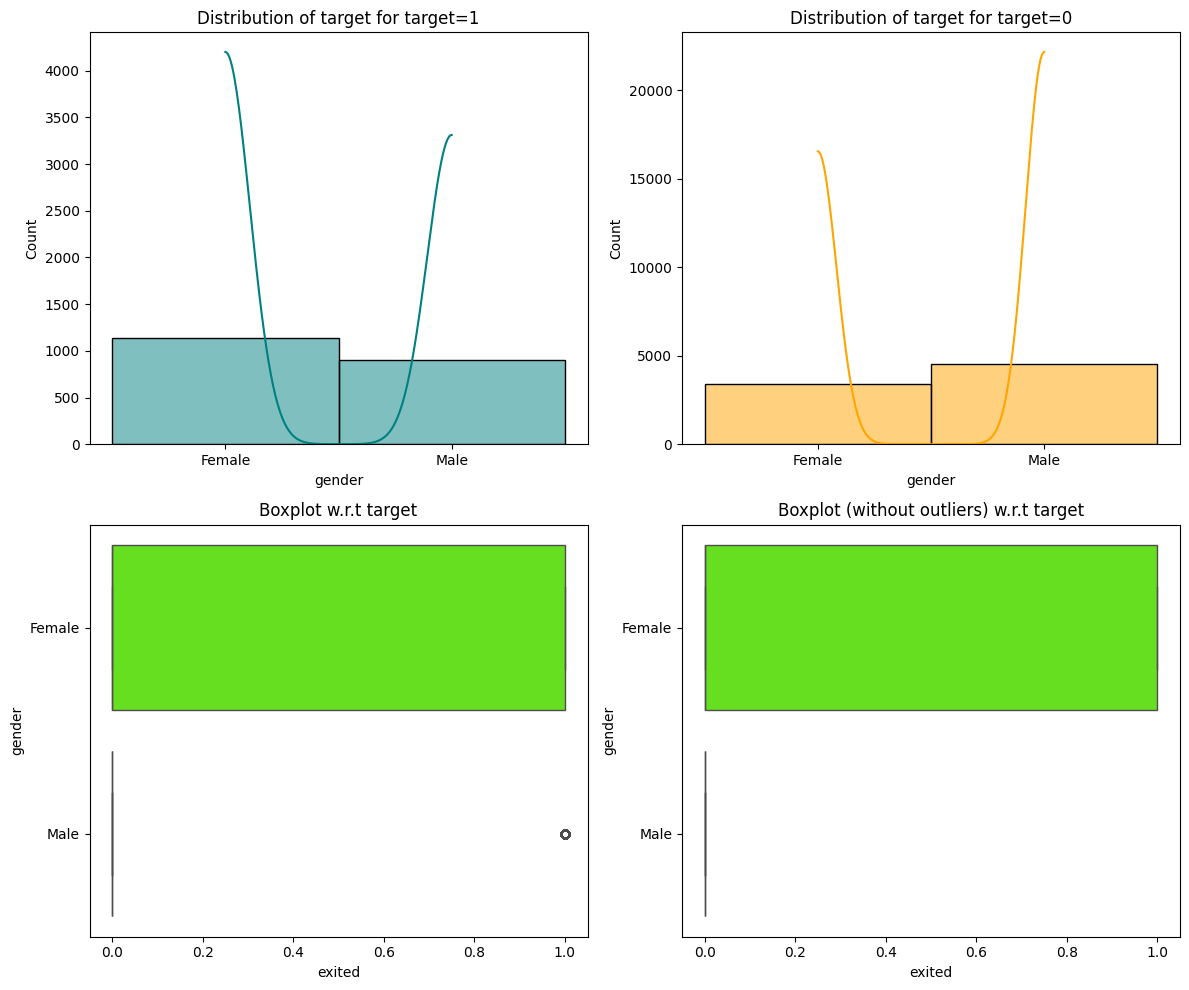

In [ ]:
# Compare gender of customer to whether they exited
distribution_plot_wrt_target(data, 'gender', 'exited')

Gender Observations


*   Women are more likely to leave then men.  Not sure why.



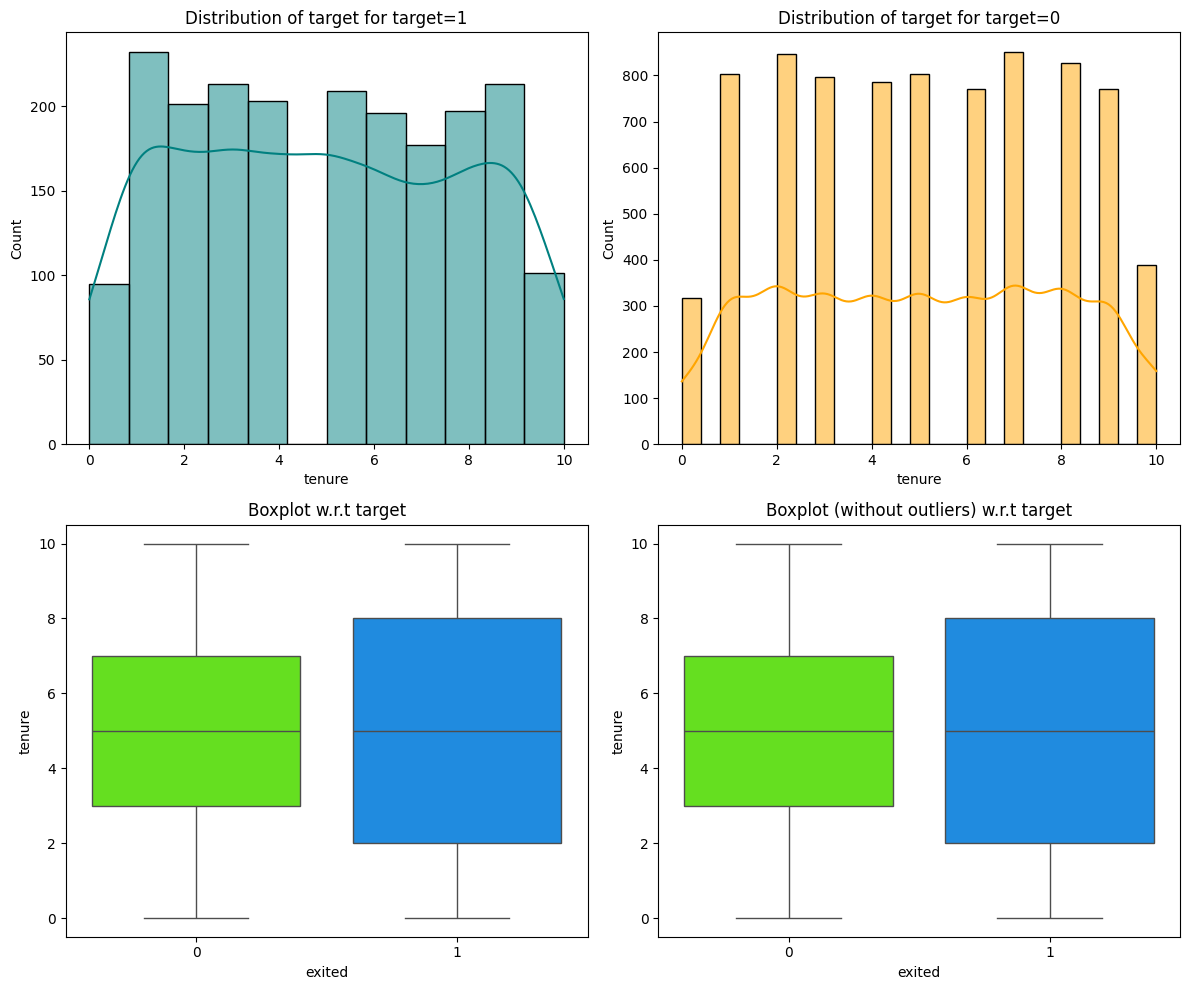

In [ ]:
# Compare tenure to whether they exited.
distribution_plot_wrt_target(data, 'tenure', 'exited')

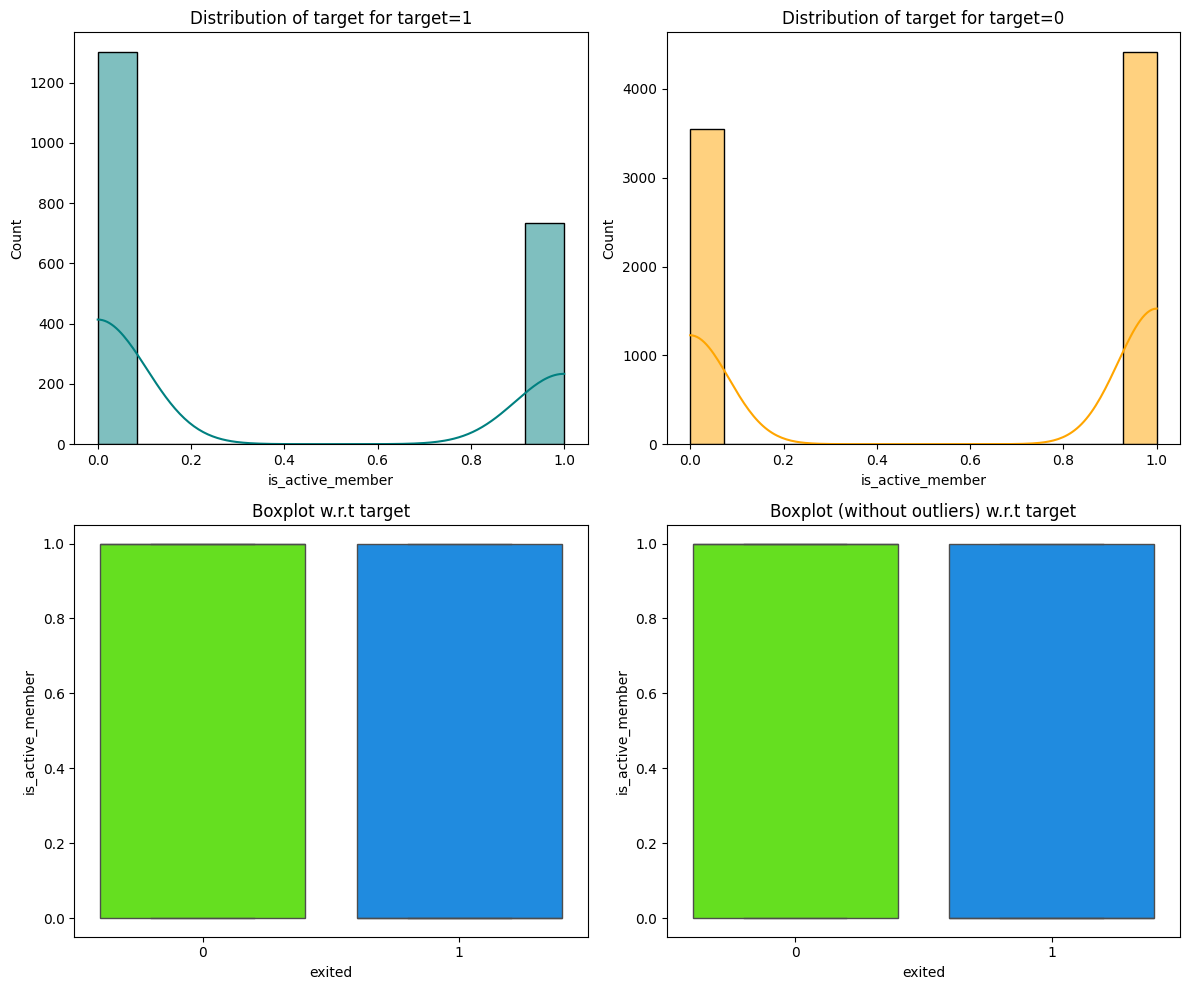

In [ ]:
# Compare whether an active member decides to leave the company.
distribution_plot_wrt_target(data, 'is_active_member', 'exited')

Active Member Observations


*   Inactive customers are more likely to exit the company.



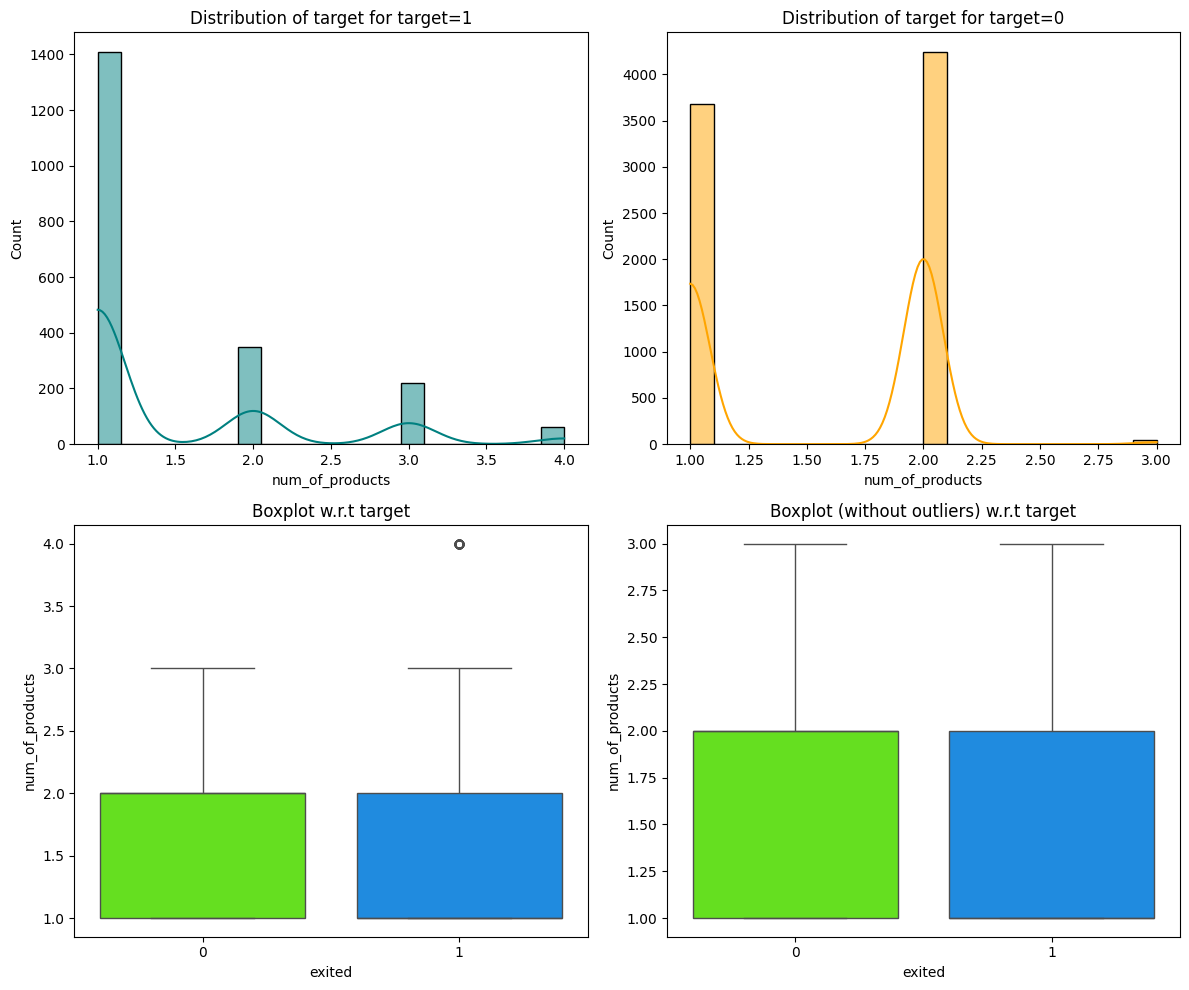

In [ ]:
# Compare number of products a customer uses to whether they leave.
distribution_plot_wrt_target(data, 'num_of_products', 'exited')

exited              0     1    All
num_of_products                   
All              7963  2037  10000
1                3675  1409   5084
2                4242   348   4590
3                  46   220    266
4                   0    60     60
------------------------------------------------------------------------------------------------------------------------


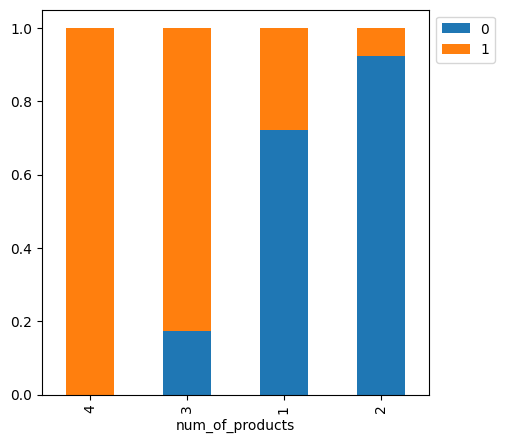

In [ ]:
# Compare Number of Products for customers with a stacked barplot.
stacked_barplot(data, 'num_of_products', 'exited')

Number of Products Observations


*   Customers who use the least amount of products were most likely to exit.
*   There were more customers that used only one product than customers using multiple products.
* For customers that have stayed the more products are more numerous.
* No customer that used 4 or more products exited the company.



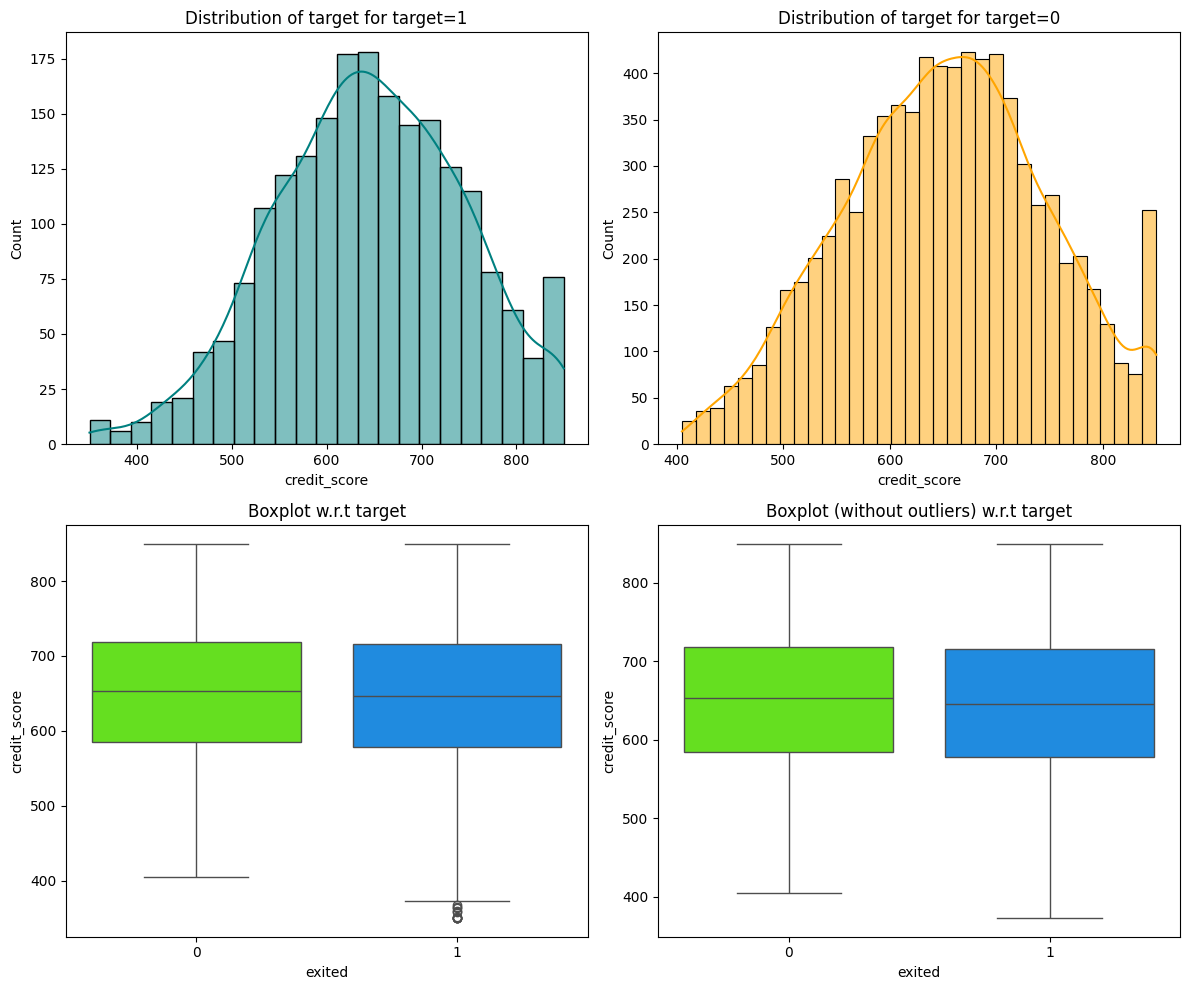

In [ ]:
# Compare credit score to whether they exited.
distribution_plot_wrt_target(data, 'credit_score', 'exited')

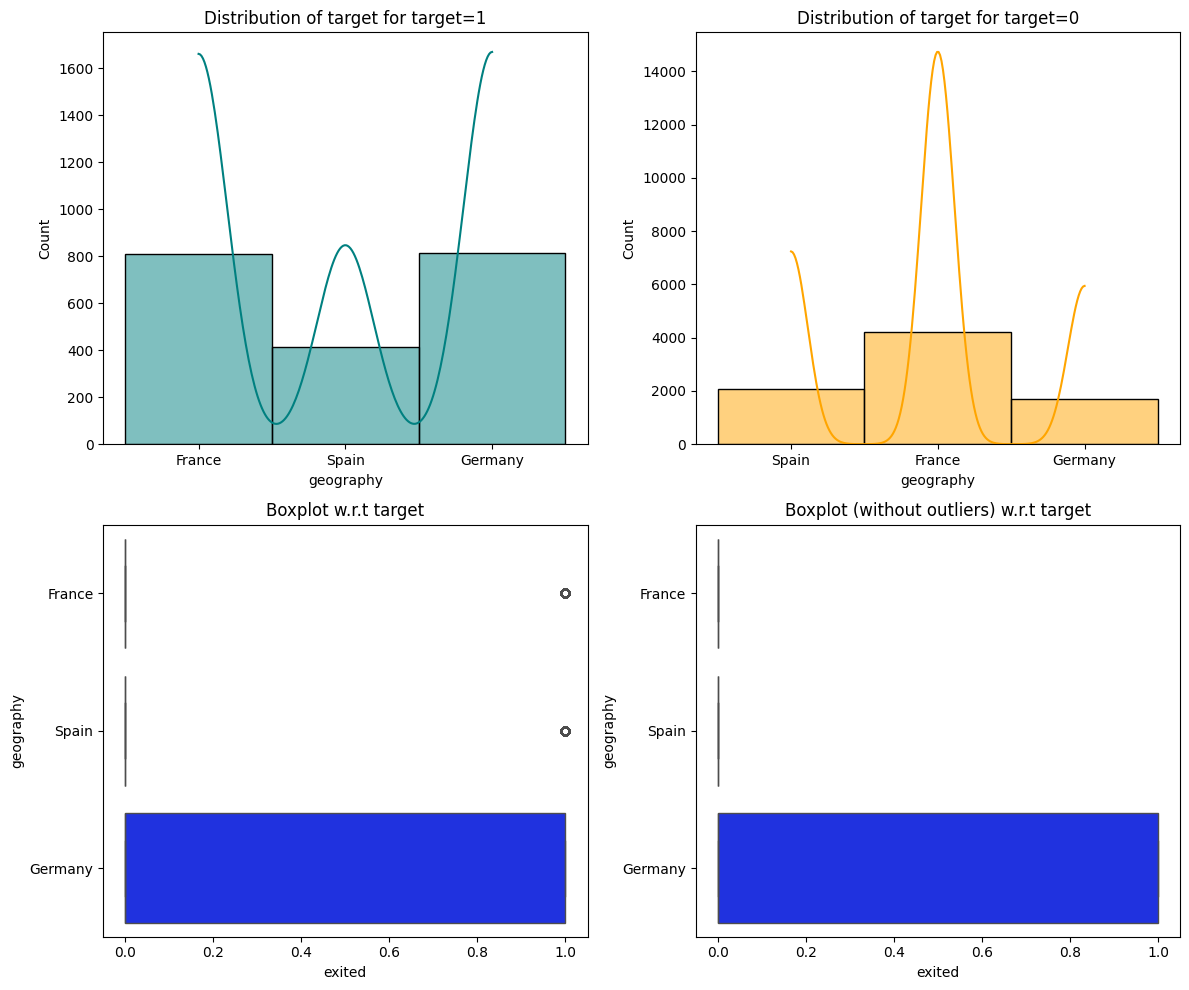

In [ ]:
# Compare geography to whether they exited.
distribution_plot_wrt_target(data, 'geography', 'exited')

Geography Observations


*   More French nationals stayed than Spanish and German.
*   Most customers have stayed but French and German left but at a smaller rate.



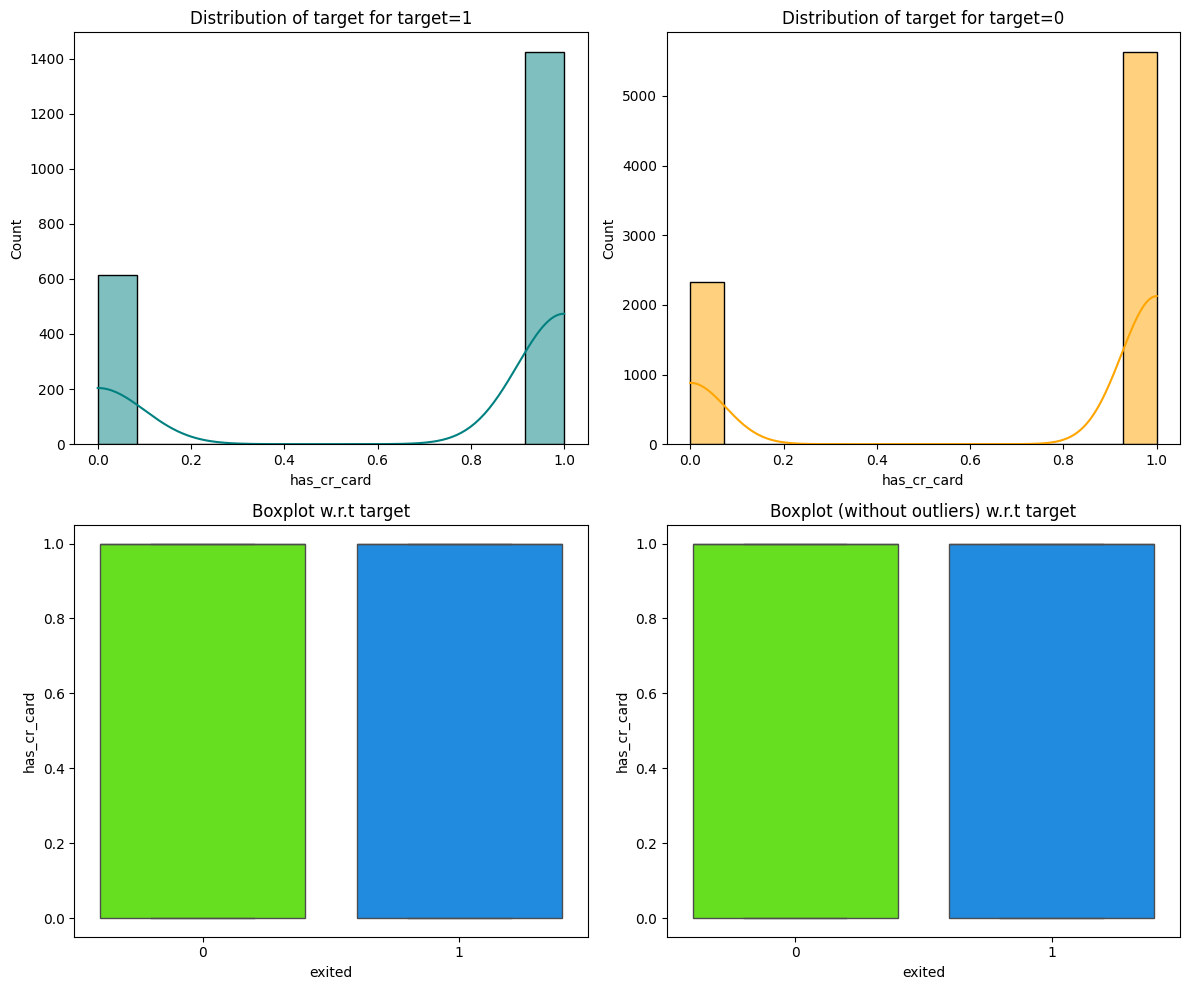

In [ ]:
# Compare if customer has a CR Card to whether they exited.
distribution_plot_wrt_target(data, 'has_cr_card', 'exited')

Has Credit Card Observations


*   There's no correlation of churn whether customer as a Credit card or not.


### Correlation Check

In [ ]:
# Drop columns that are least relevant to the data.
drop_columns = ['row_number', 'customer_id', 'surname']

# Drop columns, ignoring errors if a column does not exist
data = data.drop(columns=drop_columns, axis=1, errors='ignore')

# Note: Run this first and only click this once otherwise you have to load the data again!

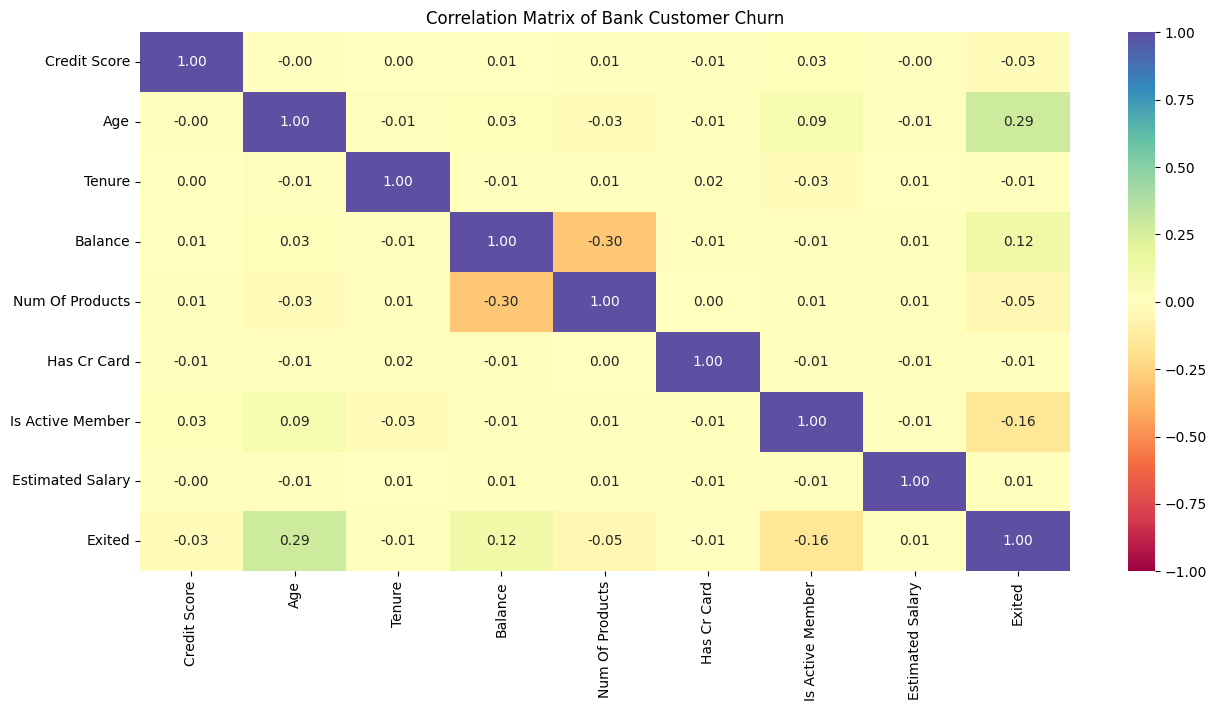

In [ ]:
# Correlation Check

# Exclude columns row_number, customer_id and surname as they are not needed for the matrix.
corr_data = data.copy()

for col in corr_data.columns:
    new_col_name = col.replace('_', ' ').title()
    corr_data[new_col_name] = corr_data[col]
    corr_data.drop(columns=col, inplace=True)

plt.figure(figsize=(15, 7))
sns.heatmap(corr_data.corr(numeric_only = True), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.title('Correlation Matrix of Bank Customer Churn')
plt.show()

del corr_data

Heatmap Observations


*   Age is the biggest factor in exiting the company.
*   The least correlation is the number of products and the bank balance.  The higher the number of products the least the balance it is.



## Data Preprocessing

### Dummy Variable Creation

In [ ]:
# Note: Run this first and only click this once otherwise you have to load the data again!

# Gender, Geography should be converted to integers
categorical_columns = ['gender', 'geography']

# Generate dummy variables and drop the first category to prevent multicollinearity
dummy_obj = pd.get_dummies(data[categorical_columns], drop_first=True)

# Concatenate the dummy variables with the original dataset and drop original categorical columns
data = pd.concat([data.drop(categorical_columns, axis=1), dummy_obj], axis=1)

# The Gender and Geography columns are now Gender_Male, Geography_Germany, Geography_Spain

### Train-validation-test Split

In [ ]:
# Creating train and test data
# (Independent) variables are to be used in making a prediction and are independent of one another.
# (Dependent) target variable is 'exited'
X = data.drop('exited', axis=1)
y = data['exited']

# Split the data into training and testing sets
# First split data into two parts (temp and test) 80% Training, 20% Test Size
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TESTING_SPLIT,
    random_state=SEED,
    stratify=y
  )

# Then we split the temporary set into train and validation.
# Splits the remaining 80% into validatation (25% of 80%) and 75% into Final training set.

# Data splits into
# 60% for Training (X_train, y_train)
# 20% for Validation (X_valid, y_valid)
# 20% for Testing (X_test, y_test)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=VALIDATION_SPLIT,
    random_state=SEED,
    stratify=y_train
  )

In [ ]:
# Printing the shapes
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_valid: {y_valid.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (6000, 11)
Shape of X_valid: (2000, 11)
Shape of X_test: (2000, 11)
Shape of y_train: (6000,)
Shape of y_valid: (2000,)
Shape of y_test: (2000,)


### Data Normalization

In [ ]:
# Define a function to compute different metrics to check performance of a classification model built using stats models
def model_performance_classification(model: Sequential, predictors: pd.DataFrame, target: pd.Series, threshold:float=0.5) -> pd.DataFrame:

  """
  Function to compute different metrics to check classification model performance
  model: classifer
  predictors: independent variables
  target: target variable
  threshold: threshold for classification
  """

  # Checking which probabilities are greater than threshold
  pred = model.predict(predictors) > threshold

  acc = accuracy_score(target, pred)
  prec = precision_score(target, pred, average='weighted')
  rec = recall_score(target, pred, average='weighted')
  f1 = f1_score(target, pred, average='weighted')

  data_perform = pd.DataFrame({'Accuracy': [acc], 'Precision': [prec], 'Recall': [rec], 'F1': [f1]})

  return data_perform

In [ ]:
# Define plot to determine model performance
def plot_model_performance(mod_hist: History, label: str, title: str = "") -> None:

    """
    Function to plot loss/accuracy

    mod_hist: an object which stores the metrics and losses.
    label: can be one of Loss or Accuracy
    """

    fig, ax = plt.subplots() # Creating a subplot with figure and axes.
    plt.plot(mod_hist.history[label]) # Plotting the train accuracy or train loss
    plt.plot(mod_hist.history['val_'+label.lower()]) # Plotting the validation accuracy or validation loss

    plt.title(f'{title.title()} Model: {label.title()}') # Defining the title of the plot.
    plt.ylabel(label.capitalize()) # Capitalizing the first letter.
    plt.xlabel('Epochs') # Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") # Defining the legend, loc controls the position of the legend.


In [ ]:
# Lets perform data normlization to scale data into a specific range.
# Select only the numeric features for scaling
numeric_features = X_train.select_dtypes(include=['number']).columns

scaler = MinMaxScaler()

# Fit the scaler on the numeric features of the training data
X_train_normalized = X_train.copy() # Create a copy to avoid modifying the original DataFrame
X_train_normalized[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# Transform the validation and test data using the fitted scaler, only for numeric features
X_valid_normalized = X_valid.copy()
X_valid_normalized[numeric_features] = scaler.transform(X_valid[numeric_features])

X_test_normalized = X_test.copy()
X_test_normalized[numeric_features] = scaler.transform(X_test[numeric_features])

## Model Building

In [ ]:
# ==================================
#  SEEDING FOR REPRODUCIBILITY
# ==================================
# Fixing the seed for random number generators
import random

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
import warnings  # To suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define Callbacks.
# This is to prevent runtime errors and note benchmarks.
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
# Returns history
def fit_model(mod: Sequential, x_train_data: pd.DataFrame, y_train_data: pd.Series, x_valid_data: pd.DataFrame, y_valid_data: pd.Series) -> History:
    return mod.fit(
        x_train_data,
        y_train_data,
        validation_data=(x_valid_data, y_valid_data),
        epochs=EPOCH_CNT,
        batch_size=BATCH_CNT,
        verbose=2,
        callbacks=[early_stopping, model_checkpoint],
    )


# Compiles the model and returns it
def compile_model(mod: Sequential, optimizer: Union[Adam, SGD, str]) -> Sequential:
    mod.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=['accuracy', 'Precision', 'Recall', 'AUC'],
    )

    return mod

In machine learning, training a model means finding the best set of internal weights and biases that minimize the model's loss (error) on the training data. The process of searching for this minimum is called optimization.

SGD is the most fundamental optimization algorithm.

Choose the metric of choice with proper rationale - Train a Neural Network model with SGD as an optimizer.



In [ ]:
# ==================================
#  Model: Neural Network (SGD)
# ==================================
title = 'Neural Network (SGD)'

In [ ]:
# Clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
FEATURE_CNT = X_train_normalized.shape[1]

In [ ]:
# Choose the metric of choice with proper rationale - Train a Neural Network model with SGD as an optimizer
# Initializing the model
sgd_model = Sequential()

# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
sgd_model.add(Dense(NEURON_CNT, activation='relu', kernel_initializer='he_uniform', input_dim=FEATURE_CNT))

# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
sgd_model.add(Dense(DEFAULT_NEURON_CNT, activation='relu', kernel_initializer='he_uniform'))

# Adding the second hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
sgd_model.add(Dense(DEFAULT_NEURON_CNT, activation='relu', kernel_initializer='he_uniform'))

# Adding the output layer with one neuron and sigmoid as activation.  This squashes the output to a probability between 0 and 1, which is necessary for classification.
#sgd_model.add(Dense(1, activation='linear'))
sgd_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Output is the model summary from Keras/TensorFlow.
sgd_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,937 (15.38 KB)

 Trainable params: 3,937 (15.38 KB)

 Non-trainable params: 0 (0.00 B)

Observations


*   The summary of the model shows each layer's name, type, output shape, and the number of parameters at that particular layer.
* X_train.shape[1] = 11.
* In the first dense layer the parameters are calculated by the number of outputs from the previous layer multiplied by the number of neurons in the seond layer plus bias. (64 * (11 + 1)) = 960.
*   In the second layer total parameters are calculated by the other number of neurons in the hidden layer multiplied by the number of variables fed to neural networks plus bias. (64 +1) * 32 = 2080.
* In the third layer the number of neurons is multiplied by itself plus one parameter (32 + 1) * 32 = 1056.
* The outside dense takes the number of neurons from the previous layer add one and multiplay by itself. (32 + 1) * 1.


In [ ]:
sgd_model = compile_model(sgd_model, 'SGD')

In [ ]:
start_time = start_timer()
sgd_model_history = fit_model(sgd_model, X_train_normalized, y_train, X_valid_normalized, y_valid)

show_banner(title, 'Training model...')
show_timer(start_time)

Epoch 1/100
188/188 - 3s - 17ms/step - AUC: 0.6104 - Precision: 0.2929 - Recall: 0.0237 - accuracy: 0.7893 - loss: 0.5025 - val_AUC: 0.6389 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.7965 - val_loss: 0.4862
Epoch 2/100
188/188 - 1s - 4ms/step - AUC: 0.6629 - Precision: 0.5000 - Recall: 8.1766e-04 - accuracy: 0.7962 - loss: 0.4776 - val_AUC: 0.6519 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.7960 - val_loss: 0.4816
Epoch 3/100
188/188 - 1s - 3ms/step - AUC: 0.6747 - Precision: 0.6667 - Recall: 0.0098 - accuracy: 0.7972 - loss: 0.4733 - val_AUC: 0.6601 - val_Precision: 0.8000 - val_Recall: 0.0098 - val_accuracy: 0.7980 - val_loss: 0.4787
Epoch 4/100
188/188 - 1s - 4ms/step - AUC: 0.6828 - Precision: 0.6170 - Recall: 0.0237 - accuracy: 0.7980 - loss: 0.4703 - val_AUC: 0.6657 - val_Precision: 0.6364 - val_Recall: 0.0172 - val_accuracy: 0.7980 - val_loss: 0.4765
Epoch 5/100
188/188 - 1s - 4ms/step - AUC: 0.6885 - Precision: 0.6364 - Rec

In [ ]:
# Get model training perfomance
sgd_model_train_perf = model_performance_classification(sgd_model, X_train, y_train)

show_banner(title, 'Training Performance')
sgd_model_train_perf

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# ======================
#  Neural Network (SGD)
# ======================
# Training Performance




,Accuracy,Precision,Recall,F1
0,0.410667,0.640673,0.410667,0.458228


In [ ]:
# Get model validation performance
sgd_model_valid_perf = model_performance_classification(sgd_model, X_valid, y_valid)

show_banner(title, 'Validation Performance')
sgd_model_valid_perf

#
# Accuracy	Precision	Recall	F1
# 0	0.7965	0.634412	0.7965	0.706276

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# ======================
#  Neural Network (SGD)
# ======================
# Validation Performance




,Accuracy,Precision,Recall,F1
0,0.3885,0.633874,0.3885,0.432983


Model Training and Validation Observations

*   Nearly ~80% of the model was correctly classified.
*   63.5% of the positive predictions made by the model are correct.
*  79.6% of the actual positives are correct.
* (Harmonic Mean of Precision and Recall) means the balance between Precision and Recall was 70.6%.
* Validation performance is similar to training performance.



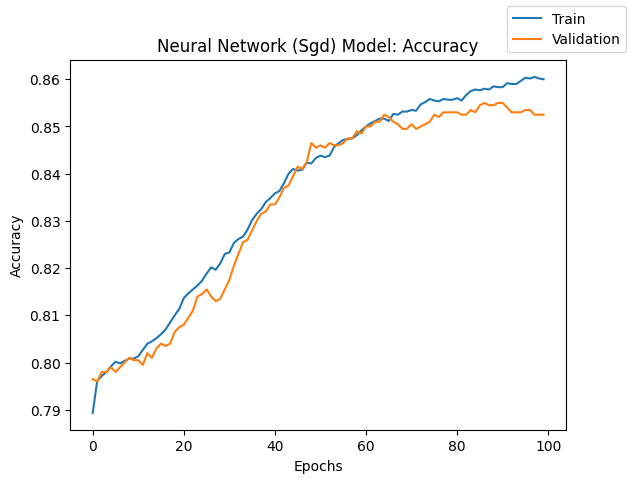

In [ ]:
# Plot training and validation accuracy
plot_model_performance(sgd_model_history, 'accuracy', title)

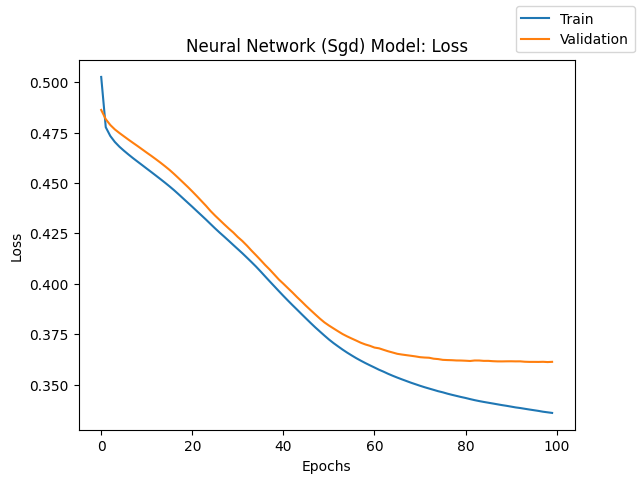

In [ ]:
plot_model_performance(sgd_model_history, 'loss', title)

Observations


* The model heavily favors the majority class and ignores the minority class. This is likely due to: Class imbalance: Class 0 has many more instances than class 1.
* Validation accuracy flatlines above 80% regardless of epochs.  
* Validatoin loss flatlines around ~3.
* Lack of emphasis on minority class during training.

### Model Evaluation Criterion

Write down the logic for choosing the metric that would be the best metric for this business scenario.

Since this is a binary classification task, we will be minimizing the binary_crossentropy and we can choose one optimizer out of

* SGD
* Adam
* Adam w/ Dropout
* SGD and SMOTE
* Adam and SMOTE
* Adam and SMOTE w/ Dropout

Model can make wrong prediction as:


*   Predicting a customer will actually exit.
*   Predicting a custome will not actually exit.



### Neural Network with SGD Optimizer

## Model Performance Improvement

- Use different methods mentioned below to improve the model performance
- Build a model with Adam optimizer
- Build a model with Adam optimizer and Dropout
- Build a model with balanced data by applying SMOTE and SGD optimizer
- Build a model with balanced data by applying SMOTE and Adam optimizer
- Build a model with balanced data by applying SMOTE, Adam optimizer and Dropout - Comment on model performance for each of the models
- Choose the best model from the ones built with proper reasoning.

### Neural Network with Adam Optimizer
#### Model #1

In [ ]:
# ==================================
#  Model: Neural Network (Adam Optimizer)
# ==================================
title = 'Neural Network (Adam Optimizer)'

In [ ]:
# Clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
FEATURE_CNT = X_train.shape[1] # value = 11

In [ ]:
# Assuming X (features) and y (target) are already defined

# Build the Neural Network
adam_model = Sequential()
adam_model.add(Dense(NEURON_CNT, activation='relu', input_dim=FEATURE_CNT))  # First hidden layer
adam_model.add(Dense(DEFAULT_NEURON_CNT, activation='relu'))  # Second hidden layer
adam_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [ ]:
adam_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

### Neural Network with Adam Optimizer and Dropout
#### Model #1 continued

In [ ]:
# Compile the model with Adam optimizer
adam_optimizer = Adam(learning_rate=LEARNING_RATE)  # Set a learning rate of 0.001

In [ ]:
# Compile Model
adam_model = compile_model(adam_model, adam_optimizer)

In [ ]:
# Fit Model
start_time = start_timer()
adam_model_history = fit_model(adam_model, X_train_normalized, y_train, X_valid_normalized, y_valid)

show_banner(title, 'Training Model...')
show_timer(start_time)

Epoch 1/100
188/188 - 1s - 4ms/step - AUC: 0.8706 - Precision: 0.7718 - Recall: 0.4702 - accuracy: 0.8637 - loss: 0.3282 - val_AUC: 0.8457 - val_Precision: 0.7545 - val_Recall: 0.4152 - val_accuracy: 0.8535 - val_loss: 0.3587
Epoch 2/100
188/188 - 1s - 3ms/step - AUC: 0.8710 - Precision: 0.7742 - Recall: 0.4710 - accuracy: 0.8642 - loss: 0.3277 - val_AUC: 0.8455 - val_Precision: 0.7545 - val_Recall: 0.4152 - val_accuracy: 0.8535 - val_loss: 0.3588
Epoch 3/100
188/188 - 1s - 3ms/step - AUC: 0.8715 - Precision: 0.7714 - Recall: 0.4718 - accuracy: 0.8638 - loss: 0.3272 - val_AUC: 0.8454 - val_Precision: 0.7556 - val_Recall: 0.4177 - val_accuracy: 0.8540 - val_loss: 0.3588
Epoch 4/100
188/188 - 1s - 3ms/step - AUC: 0.8718 - Precision: 0.7736 - Recall: 0.4751 - accuracy: 0.8647 - loss: 0.3268 - val_AUC: 0.8454 - val_Precision: 0.7522 - val_Recall: 0.4177 - val_accuracy: 0.8535 - val_loss: 0.3591
Epoch 5/100
188/188 - 1s - 5ms/step - AUC: 0.8723 - Precision: 0.7750 - Recall: 0.4759 - accurac

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_auc = adam_model.evaluate(X_test_normalized, y_test, verbose=2)

63/63 - 0s - 3ms/step - AUC: 0.8551 - Precision: 0.7750 - Recall: 0.4570 - accuracy: 0.8625 - loss: 0.3434


In [ ]:
# Get model 1 training performance for Adam
adam_model_train_perf = model_performance_classification(adam_model, X_train_normalized, y_train)

show_banner(title, 'Training Performance')
adam_model_train_perf

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


# =================================
#  Neural Network (Adam Optimizer)
# =================================
# Training Performance




,Accuracy,Precision,Recall,F1
0,0.868167,0.861072,0.868167,0.855262


In [ ]:
# Get model 1 validation performance for Adam
adam_model_valid_perf = model_performance_classification(adam_model, X_valid_normalized, y_valid)

show_banner(title, 'Validation Performance')
adam_model_valid_perf

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# =================================
#  Neural Network (Adam Optimizer)
# =================================
# Validation Performance




,Accuracy,Precision,Recall,F1
0,0.8535,0.843295,0.8535,0.836235


Adam Optimized Training and Validation Performance Observations


* Nearly ~87% of the model was correctly classified. (in training).
* 86% of the positive predictions made by the model are correct.
* 87% of the actual positives are correct.
* (Harmonic Mean of Precision and Recall) means the balance between Precision and Recall was 85%.
* Validation performance is similar to training performance.
* The difference gap is smaller when adding the Adam Optimizer compared to SGD.  The sensitivity or true positive rate is lower.



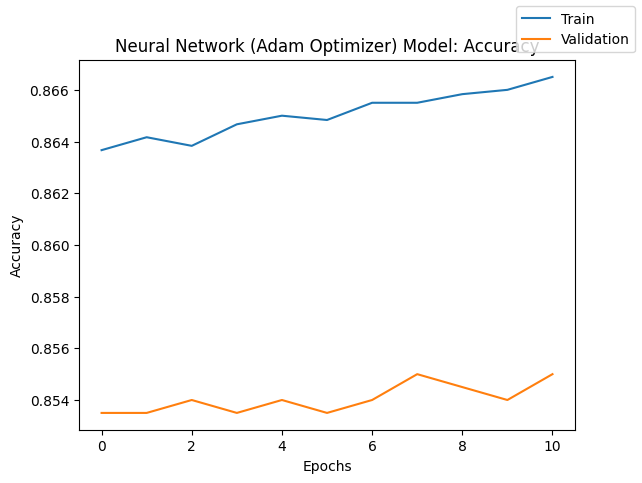

In [ ]:
# Plot training and validation accuracy
plot_model_performance(adam_model_history, 'accuracy', title)

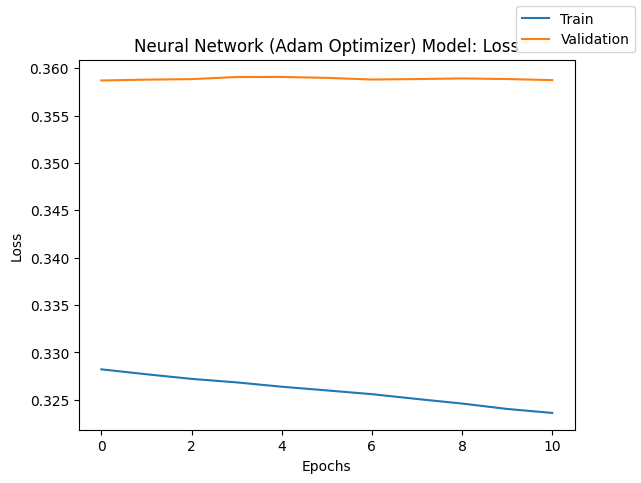

In [ ]:
# Plot training and validation loss
plot_model_performance(adam_model_history, 'loss', title)

Adam Plot Training and Validation Performance Observations


*   The accuracy increases with the epoch which means it's learning!
*   The test loss decreases as the epochs increase.
* The training data loss decreases as well so the validation and training data are more correlated.





---



### Adam Optimized Model with Dropout

In [ ]:
# ==================================
#  Model: Neural Network (Adam and Dropout)
# ==================================
title = 'Neural Network (Adam and Dropout)'

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
FEATURE_CNT = X_train_normalized.shape[1]

In [ ]:
# Load and preprocess the data

# Build the Neural Network
adam_drop_model = Sequential()

# Add layers using .add()
adam_drop_model.add(Dense(NEURON_CNT, activation='relu', kernel_initializer='he_uniform', input_dim=FEATURE_CNT))  # First hidden layer
adam_drop_model.add(Dropout(DROPOUT_RATE))  # Dropout with 25% rate
adam_drop_model.add(Dense(DEFAULT_NEURON_CNT, activation='relu', kernel_initializer='he_uniform'))  # Second hidden layer
adam_drop_model.add(Dropout(DROPOUT_RATE))  # Dropout with 25% rate
adam_drop_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [ ]:
adam_drop_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

### Adam Optimzer and Dropout Observations
### Model #2

*   Using a 25% dropout rate.
*   11 neurons * 64 = 768.

In [ ]:
# Compile the model with Adam optimizer and dropout
adam_optimizer = Adam(learning_rate=LEARNING_RATE)

In [ ]:
# Optimize Model
adam_drop_model = compile_model(adam_drop_model, adam_optimizer)

In [ ]:
# Fit Model
start_time = start_timer()
adam_drop_model_history = fit_model(adam_drop_model, X_train_normalized, y_train, X_valid_normalized, y_valid)

show_banner(title, 'Training Model...')
show_timer(start_time)

Epoch 1/100
188/188 - 5s - 25ms/step - AUC: 0.5833 - Precision: 0.3113 - Recall: 0.0384 - accuracy: 0.7867 - loss: 0.5149 - val_AUC: 0.6787 - val_Precision: 0.6000 - val_Recall: 0.0147 - val_accuracy: 0.7975 - val_loss: 0.4723
Epoch 2/100
188/188 - 1s - 3ms/step - AUC: 0.6781 - Precision: 0.5157 - Recall: 0.0670 - accuracy: 0.7970 - loss: 0.4764 - val_AUC: 0.7015 - val_Precision: 0.6429 - val_Recall: 0.0442 - val_accuracy: 0.8005 - val_loss: 0.4618
Epoch 3/100
188/188 - 1s - 3ms/step - AUC: 0.6971 - Precision: 0.5837 - Recall: 0.0998 - accuracy: 0.8020 - loss: 0.4675 - val_AUC: 0.7163 - val_Precision: 0.6944 - val_Recall: 0.0614 - val_accuracy: 0.8035 - val_loss: 0.4544
Epoch 4/100
188/188 - 1s - 4ms/step - AUC: 0.7013 - Precision: 0.6440 - Recall: 0.1006 - accuracy: 0.8053 - loss: 0.4638 - val_AUC: 0.7344 - val_Precision: 0.7143 - val_Recall: 0.1229 - val_accuracy: 0.8115 - val_loss: 0.4442
Epoch 5/100
188/188 - 1s - 3ms/step - AUC: 0.7205 - Precision: 0.5825 - Recall: 0.1357 - accura

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_auc = adam_drop_model.evaluate(X_test_normalized, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

63/63 - 0s - 4ms/step - AUC: 0.8501 - Precision: 0.8177 - Recall: 0.3857 - accuracy: 0.8575 - loss: 0.3482
Test Accuracy: 0.86


Observation


*   Validation declines a bit after a few epochs then the difference is subtle.
* The training data declines vastly at first then is a bit volatile while downtrending as the epochs increase.

In [ ]:
# Get Model #2 training performance for Adam with dropout
adam_drop_model_train_perf = model_performance_classification(adam_drop_model, X_train_normalized, y_train)

show_banner(title, 'Training Performance')
adam_drop_model_train_perf

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# ===================================
#  Neural Network (Adam and Dropout)
# ===================================
# Training Performance




,Accuracy,Precision,Recall,F1
0,0.864833,0.862735,0.864833,0.845612


In [ ]:
# Get Model 2 training performance for Adam with dropout
adam_drop_model_valid_perf = model_performance_classification(adam_drop_model, X_valid_normalized, y_valid)

show_banner(title, 'Validation Performance')
adam_drop_model_valid_perf

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# ===================================
#  Neural Network (Adam and Dropout)
# ===================================
# Validation Performance




,Accuracy,Precision,Recall,F1
0,0.853,0.846493,0.853,0.830823


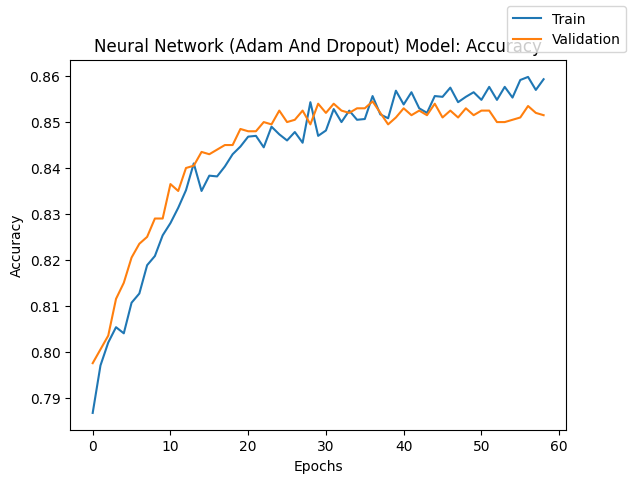

In [ ]:
# Plot training and validation accuracy
plot_model_performance(adam_drop_model_history, 'accuracy', title)

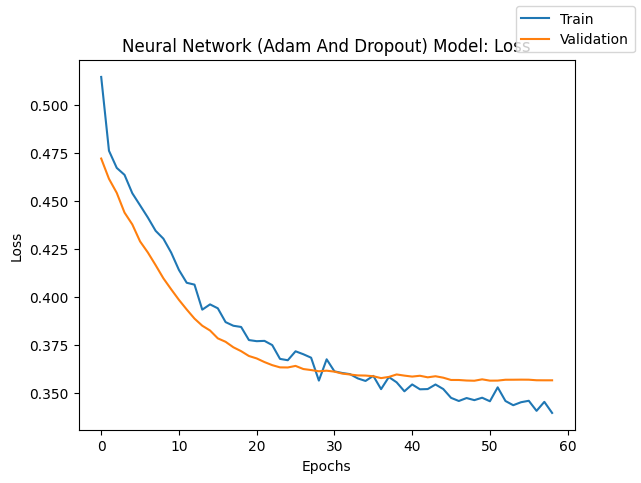

In [ ]:
# Plot training and validation loss
plot_model_performance(adam_drop_model_history, 'loss', title)

Adam with Dropout Plot Training and Validation Performance Observations


*   The training accuracy is almost the inverse of the training loss.
*   The validation increases as the epoch increases but is not has high as the training accuracy.
* The training accuracy increases at the very beginning and then fluctuates as the epochs increase. Overall it gets better which means it's learning.



### Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer
#### Model #3

In [ ]:
# ==================================
#  Model #3: Neural Network (SGD with SMOTE)
# ==================================
title = 'Neural Network (SGD with SMOTE)'

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
# Apply SMOTE for balancing
smote = SMOTE(random_state=SEED)
X_smote, y_smote = smote.fit_resample(X_train_normalized, y_train)

print("Shape of X_smote:", X_smote.shape)
print("Shape of y_smote:", y_smote.shape)

print(X_smote.isna().sum())  # Check if there are any NaNs in the feature set
print(np.isnan(X_smote).sum())  # Check if there are any NaNs in the feature set

Shape of X_smote: (9554, 11)
Shape of y_smote: (9554,)
credit_score         0
age                  0
tenure               0
balance              0
num_of_products      0
has_cr_card          0
is_active_member     0
estimated_salary     0
gender_Male          0
geography_Germany    0
geography_Spain      0
dtype: int64
credit_score         0
age                  0
tenure               0
balance              0
num_of_products      0
has_cr_card          0
is_active_member     0
estimated_salary     0
gender_Male          0
geography_Germany    0
geography_Spain      0
dtype: int64


In [ ]:
FEATURE_CNT = X_smote.shape[1]

In [ ]:
# Build the Neural Network
sgd_smote_model = Sequential()

# Add layers using .add()
sgd_smote_model.add(Dense(NEURON_CNT, activation='relu', kernel_initializer='he_uniform', input_dim=FEATURE_CNT))  # First hidden layer
sgd_smote_model.add(Dense(DEFAULT_NEURON_CNT, kernel_initializer='he_uniform', activation='relu'))  # Second hidden layer
sgd_smote_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [ ]:
# Get summary of Model 3
sgd_smote_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model with SGD optimizer
sgd_optimizer = SGD(learning_rate=LEARNING_RATE, momentum=0.9)

In [ ]:
# Compile Model
sgd_smote_model = compile_model(sgd_smote_model, sgd_optimizer)

In [ ]:
# Fit Model
start_time = start_timer()
sgd_smote_model_history = fit_model(sgd_smote_model, X_smote, y_smote, X_valid_normalized, y_valid)

show_banner(title, 'Training Model...')
show_timer(start_time)

Epoch 1/100
299/299 - 3s - 10ms/step - AUC: 0.6231 - Precision: 0.6160 - Recall: 0.5332 - accuracy: 0.6004 - loss: 0.6725 - val_AUC: 0.6593 - val_Precision: 0.2862 - val_Recall: 0.6658 - val_accuracy: 0.5940 - val_loss: 0.6803
Epoch 2/100
299/299 - 2s - 7ms/step - AUC: 0.6944 - Precision: 0.6533 - Recall: 0.6339 - accuracy: 0.6487 - loss: 0.6374 - val_AUC: 0.6839 - val_Precision: 0.3069 - val_Recall: 0.6757 - val_accuracy: 0.6235 - val_loss: 0.6637
Epoch 3/100
299/299 - 1s - 3ms/step - AUC: 0.7107 - Precision: 0.6603 - Recall: 0.6412 - accuracy: 0.6556 - loss: 0.6257 - val_AUC: 0.6973 - val_Precision: 0.3131 - val_Recall: 0.6830 - val_accuracy: 0.6305 - val_loss: 0.6555
Epoch 4/100
299/299 - 1s - 3ms/step - AUC: 0.7220 - Precision: 0.6706 - Recall: 0.6575 - accuracy: 0.6673 - loss: 0.6173 - val_AUC: 0.7080 - val_Precision: 0.3132 - val_Recall: 0.6880 - val_accuracy: 0.6295 - val_loss: 0.6493
Epoch 5/100
299/299 - 1s - 4ms/step - AUC: 0.7315 - Precision: 0.6760 - Recall: 0.6703 - accura

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_auc = sgd_smote_model.evaluate(X_test_normalized, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

63/63 - 0s - 3ms/step - AUC: 0.8441 - Precision: 0.4198 - Recall: 0.7715 - accuracy: 0.7365 - loss: 0.5100
Test Accuracy: 0.74


In [ ]:
# Generate classification report
y_pred = (sgd_smote_model.predict(X_test_normalized) > 0.5).astype("int32")

show_banner(title, 'Classification Report')
print(classification_report(y_test, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# =================================
#  Neural Network (SGD with SMOTE)
# =================================
# Classification Report


              precision    recall  f1-score   support

           0       0.93      0.73      0.81      1593
           1       0.42      0.77      0.54       407

    accuracy                           0.74      2000
   macro avg       0.67      0.75      0.68      2000
weighted avg       0.82      0.74      0.76      2000



In [ ]:
# Get Model 3 training performance for SGD Optimizer with SMOTE
sgd_smote_model_train_perf = model_performance_classification(sgd_smote_model, X_train_normalized, y_train)

show_banner(title, 'Training Performance')
sgd_smote_model_train_perf

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# =================================
#  Neural Network (SGD with SMOTE)
# =================================
# Training Performance




,Accuracy,Precision,Recall,F1
0,0.763,0.841571,0.763,0.783258


In [ ]:
# Get Model 3 validation performance for SGD Optimize with SMOTE
sgd_smote_model_valid_perf = model_performance_classification(sgd_smote_model, X_valid_normalized, y_valid)

show_banner(title, 'Validation Performance')
sgd_smote_model_valid_perf

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# =================================
#  Neural Network (SGD with SMOTE)
# =================================
# Validation Performance




,Accuracy,Precision,Recall,F1
0,0.754,0.82744,0.754,0.774405


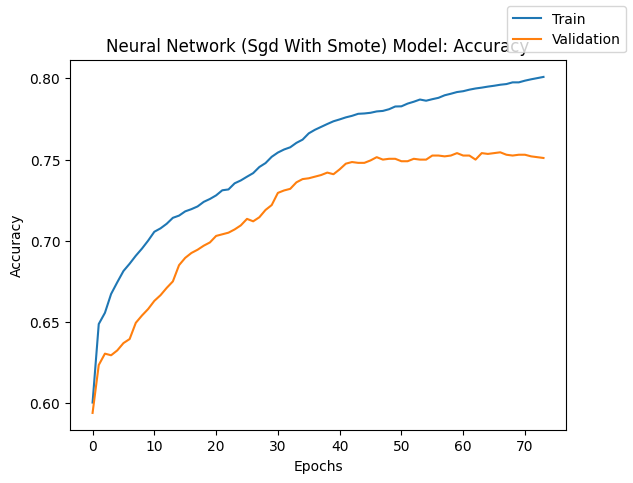

In [ ]:
plot_model_performance(sgd_smote_model_history, 'accuracy', title)

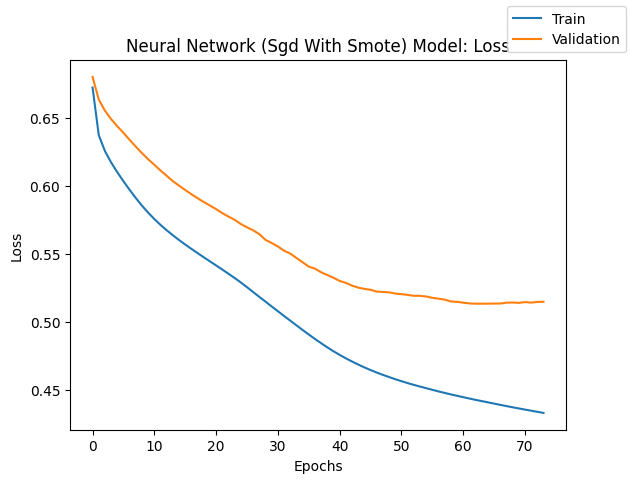

In [ ]:
plot_model_performance(sgd_smote_model_history, 'loss', title)

Model 3 Training and Validation Observations


* The training accuracy starts above 60% and gradually gets better as the epoch increase.  It means it's learning but slowly as the accuracy only increases ~10%.
*   The validation accuracy starts low but learns quickly until the 10th epoch.  Then the learning rate slows down a bit as it has hit it's peak.
* The loss of training and validation data declines as the epochs increase but training data is much more.



### Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer
#### Model #4

In [ ]:
# ==================================
#  Model: Neural Network (Adam with SMOTE)
# ==================================
title = 'Neural Network (Adam with SMOTE)'

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
# Load your dataset

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=SEED)
X_smote, y_smote = smote.fit_resample(X_train_normalized, y_train)

# Sacling the data ensure taht the neural network performs better, espcially with certain activation functions.
X_smote_scaled = scaler.fit_transform(X_smote)

# Check the shapes of the balanced data
print("Shape of X_smote:", X_smote.shape)
print("Shape of y_smote:", y_smote.shape)
print("Shape of X_smote_scaled:", X_smote_scaled.shape)

# Check if there are any NaNs in the feature set
print(X_smote.isna().sum())

Shape of X_smote: (9554, 11)
Shape of y_smote: (9554,)
Shape of X_smote_scaled: (9554, 11)
credit_score         0
age                  0
tenure               0
balance              0
num_of_products      0
has_cr_card          0
is_active_member     0
estimated_salary     0
gender_Male          0
geography_Germany    0
geography_Spain      0
dtype: int64


In [ ]:
FEATURE_CNT = X_smote_scaled.shape[1]

In [ ]:
# Build the Neural Network
adam_smote_bal_model = Sequential()

# Add layers using .add()
adam_smote_bal_model.add(Dense(NEURON_CNT, activation='relu', input_dim=FEATURE_CNT, kernel_initializer='he_uniform'))  # First hidden layer
adam_smote_bal_model.add(Dense(DEFAULT_NEURON_CNT, activation='relu', kernel_initializer='he_uniform'))  # Second hidden layer
adam_smote_bal_model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

In [ ]:
# Get model summary
adam_smote_bal_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define optimizer
default_adam_optimizer = 'adam'

In [ ]:
# Compile Model
adam_smote_bal_model = compile_model(adam_smote_bal_model, default_adam_optimizer)

In [ ]:
# Fit Model
start_time = start_timer()
adam_smote_bal_model_history = fit_model(adam_smote_bal_model, X_smote_scaled, y_smote, X_valid_normalized, y_valid)

show_banner(title, 'Training Model...')
show_timer(start_time)

Epoch 1/100
299/299 - 4s - 12ms/step - AUC: 0.7173 - Precision: 0.6525 - Recall: 0.6638 - accuracy: 0.6551 - loss: 0.6173 - val_AUC: 0.7549 - val_Precision: 0.3037 - val_Recall: 0.7961 - val_accuracy: 0.5870 - val_loss: 0.6845
Epoch 2/100
299/299 - 1s - 3ms/step - AUC: 0.7817 - Precision: 0.7055 - Recall: 0.7226 - accuracy: 0.7105 - loss: 0.5649 - val_AUC: 0.7774 - val_Precision: 0.3347 - val_Recall: 0.8034 - val_accuracy: 0.6350 - val_loss: 0.6692
Epoch 3/100
299/299 - 1s - 3ms/step - AUC: 0.8083 - Precision: 0.7328 - Recall: 0.7337 - accuracy: 0.7331 - loss: 0.5372 - val_AUC: 0.7961 - val_Precision: 0.3616 - val_Recall: 0.8059 - val_accuracy: 0.6710 - val_loss: 0.6419
Epoch 4/100
299/299 - 1s - 3ms/step - AUC: 0.8320 - Precision: 0.7546 - Recall: 0.7480 - accuracy: 0.7524 - loss: 0.5090 - val_AUC: 0.8222 - val_Precision: 0.3792 - val_Recall: 0.8329 - val_accuracy: 0.6885 - val_loss: 0.6180
Epoch 5/100
299/299 - 1s - 3ms/step - AUC: 0.8520 - Precision: 0.7755 - Recall: 0.7620 - accura

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall, test_auc = adam_smote_bal_model.evaluate(X_test_normalized, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

63/63 - 0s - 3ms/step - AUC: 0.8438 - Precision: 0.4043 - Recall: 0.7887 - accuracy: 0.7205 - loss: 0.5357
Test Accuracy: 0.72


In [ ]:
# Get Model 4 training performance for Adam and SMOTE
adam_smote_bal_model_train_perf = model_performance_classification(adam_smote_bal_model, X_train_normalized, y_train)

show_banner(title, 'Training Performance')
adam_smote_bal_model_train_perf

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# ==================================
#  Neural Network (Adam with SMOTE)
# ==================================
# Training Performance




,Accuracy,Precision,Recall,F1
0,0.763333,0.85748,0.763333,0.784826


In [ ]:
# Get Model 4 validation performance for Adam and SMOTE
adam_smote_bal_model_valid_perf = model_performance_classification(adam_smote_bal_model, X_valid_normalized, y_valid)

show_banner(title, 'Validation Performance')
adam_smote_bal_model_valid_perf

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# ==================================
#  Neural Network (Adam with SMOTE)
# ==================================
# Validation Performance




,Accuracy,Precision,Recall,F1
0,0.739,0.830669,0.739,0.762393


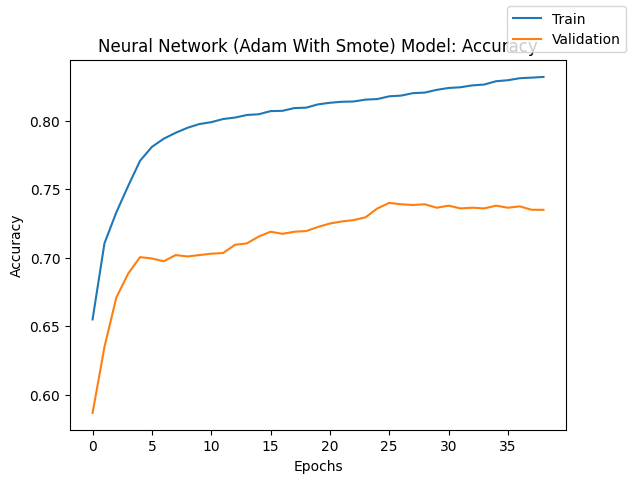

In [ ]:
plot_model_performance(adam_smote_bal_model_history, 'accuracy', title)

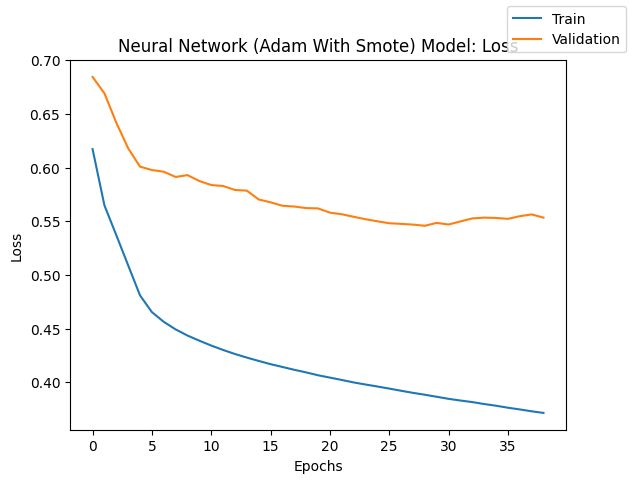

In [ ]:
plot_model_performance(adam_smote_bal_model_history, 'loss', title)

Model #4 Adam and SMOTE Training and Validation Observations


* The accuracy learns quickly at first then slows down as the epochs increase.
* Precision is at ~82% which means that it's good at identifying the positive class and predictions.
* The model performs much better on the training set.
* The F1 score is substantial and balanced (~82%).  This is good.



### Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout
#### Model #5

In [ ]:
# ==================================
#  Model: Neural Network (Adam and Dropout with SMOTE)
# ==================================
title = 'Neural Network (Adam and Dropout with SMOTE)'

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=SEED)
X_smote, y_smote = smote.fit_resample(X_train_normalized, y_train)

In [ ]:
FEATURE_CNT = X_smote.shape[1]

In [ ]:
# Build model
adam_drop_smote_bal_model = Sequential()

# Add layers using .add()
adam_drop_smote_bal_model.add(Dense(NEURON_CNT, activation='relu', input_shape=(FEATURE_CNT,)))  # First hidden layer
adam_drop_smote_bal_model.add(Dropout(DROPOUT_SMOTE_RATE))  # Dropout with 30% rate
adam_drop_smote_bal_model.add(Dense(DEFAULT_NEURON_CNT, activation='relu'))  # Second hidden layer
adam_drop_smote_bal_model.add(Dropout(DROPOUT_SMOTE_RATE))  # Dropout with 30% rate

# Output layer for binary classification
adam_drop_smote_bal_model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

In [ ]:
# Get Model 5 Summary
adam_drop_smote_bal_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam_optimizer = Adam(learning_rate=LEARNING_RATE)

In [ ]:
# Compile Model
adam_drop_smote_bal_model = compile_model(adam_drop_smote_bal_model, adam_optimizer)

In [ ]:
# Fit Model
start_time = start_timer()
adam_drop_smote_bal_model_history = fit_model(adam_drop_smote_bal_model, X_smote, y_smote, X_valid_normalized, y_valid)

show_banner(title, 'Training Model...')
show_timer(start_time)

Epoch 1/100
299/299 - 4s - 12ms/step - AUC: 0.6652 - Precision: 0.6239 - Recall: 0.6073 - accuracy: 0.6206 - loss: 0.6514 - val_AUC: 0.7143 - val_Precision: 0.3020 - val_Recall: 0.6880 - val_accuracy: 0.6130 - val_loss: 0.6475
Epoch 2/100
299/299 - 1s - 3ms/step - AUC: 0.7287 - Precision: 0.6653 - Recall: 0.6870 - accuracy: 0.6707 - loss: 0.6123 - val_AUC: 0.7480 - val_Precision: 0.3406 - val_Recall: 0.6904 - val_accuracy: 0.6650 - val_loss: 0.6125
Epoch 3/100
299/299 - 1s - 3ms/step - AUC: 0.7566 - Precision: 0.6909 - Recall: 0.7015 - accuracy: 0.6938 - loss: 0.5880 - val_AUC: 0.7646 - val_Precision: 0.3540 - val_Recall: 0.7150 - val_accuracy: 0.6765 - val_loss: 0.6019
Epoch 4/100
299/299 - 1s - 3ms/step - AUC: 0.7740 - Precision: 0.7077 - Recall: 0.7161 - accuracy: 0.7102 - loss: 0.5728 - val_AUC: 0.7751 - val_Precision: 0.3575 - val_Recall: 0.7518 - val_accuracy: 0.6745 - val_loss: 0.6139
Epoch 5/100
299/299 - 1s - 4ms/step - AUC: 0.7937 - Precision: 0.7212 - Recall: 0.7251 - accura

In [ ]:
# Evaluate Model 5
test_loss, test_accuracy, test_precision, test_recall, test_auc = adam_drop_smote_bal_model.evaluate(X_test_normalized, y_test)
print(f"Test Accuracy: {test_accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8618 - Precision: 0.4776 - Recall: 0.7468 - accuracy: 0.7987 - loss: 0.4307
Test Accuracy: 0.7820000052452087


In [ ]:
# Get Model 5 training performance
adam_drop_smote_bal_model_train_perf = model_performance_classification(adam_drop_smote_bal_model, X_train_normalized, y_train)

show_banner(title, 'Training Performance')
adam_drop_smote_bal_model_train_perf

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# ==============================================
#  Neural Network (Adam and Dropout with SMOTE)
# ==============================================
# Training Performance




,Accuracy,Precision,Recall,F1
0,0.804167,0.850635,0.804167,0.817668


In [ ]:
# Get Model 5 validation performance
adam_drop_smote_bal_model_valid_perf = model_performance_classification(adam_drop_smote_bal_model, X_valid_normalized, y_valid)

show_banner(title, 'Validation Performance')
adam_drop_smote_bal_model_valid_perf

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# ==============================================
#  Neural Network (Adam and Dropout with SMOTE)
# ==============================================
# Validation Performance




,Accuracy,Precision,Recall,F1
0,0.7805,0.824312,0.7805,0.794748


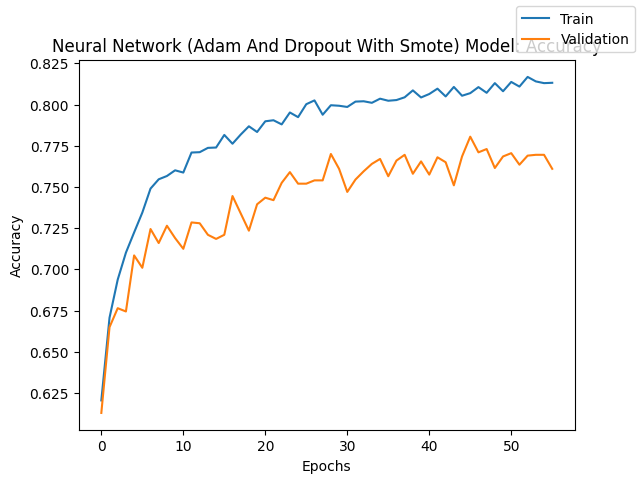

In [ ]:
plot_model_performance(adam_drop_smote_bal_model_history, 'accuracy', title)

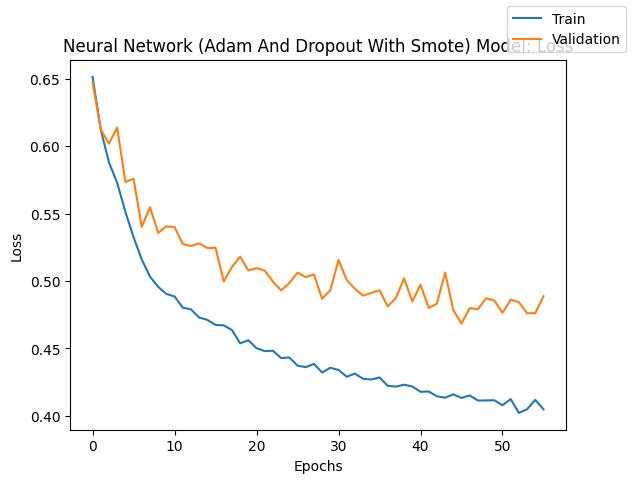

In [ ]:
plot_model_performance(adam_drop_smote_bal_model_history, 'loss', title)

Model 5 Adam Optimizer and SMOTE with Dropout Training and Validation Performance Observations


*   Accuracy increases drastically in the beginning to prove that the model is learning!
* Precision is in the mid 80% which means that it can predict positively that are accurate.
*   Recall is all high around ~80% which means the true positive rate is high.  The model can identify actual positives.
* The balance between precision and recall (F1) is just ~3%.



## Model Performance Comparison and Final Model Selection

In [ ]:
# ==================================
#  COMPARE MODELS
# ==================================

# Out of the six models lets compare the positives and negatives and make a final selection
model_columns = [
    'Neural Network (SGD)',
    'Neural Network (Adam Optimizer)',
    'Neural Network (Adam and Dropout)',
    'Neural Network (SGD with SMOTE)',
    'Neural Network (Adam with SMOTE)',
    'Neural Network (Adam and Dropout with SMOTE)'
]

In [ ]:
# Training performance comparison
models_train_comp_data = pd.concat(
    [
        sgd_model_train_perf.T,
        adam_model_train_perf.T,
        adam_drop_model_train_perf.T,
        sgd_smote_model_train_perf.T,
        adam_smote_bal_model_train_perf.T,
        adam_drop_smote_bal_model_train_perf.T,
    ],
    axis=1,
)

models_train_comp_data.columns = model_columns

In [ ]:
# Validation performance comparison
models_valid_comp_data = pd.concat([
    sgd_model_valid_perf.T,
    adam_model_valid_perf.T,
    adam_drop_model_valid_perf.T,
    sgd_smote_model_valid_perf.T,
    adam_smote_bal_model_valid_perf.T,
    adam_drop_smote_bal_model_valid_perf.T,
  ],
  axis=1,
)

models_valid_comp_data.columns = model_columns

In [ ]:
# Display Training performance data
models_train_comp_data

,Neural Network (SGD),Neural Network (Adam Optimizer),Neural Network (Adam and Dropout),Neural Network (SGD with SMOTE),Neural Network (Adam with SMOTE),Neural Network (Adam and Dropout with SMOTE)
Accuracy,0.410667,0.868167,0.864833,0.763000,0.763333,0.804167
Precision,0.640673,0.861072,0.862735,0.841571,0.857480,0.850635
Recall,0.410667,0.868167,0.864833,0.763000,0.763333,0.804167
F1,0.458228,0.855262,0.845612,0.783258,0.784826,0.817668


In [ ]:
# Display Validation performance data.
models_valid_comp_data

,Neural Network (SGD),Neural Network (Adam Optimizer),Neural Network (Adam and Dropout),Neural Network (SGD with SMOTE),Neural Network (Adam with SMOTE),Neural Network (Adam and Dropout with SMOTE)
Accuracy,0.388500,0.853500,0.853000,0.754000,0.739000,0.780500
Precision,0.633874,0.843295,0.846493,0.827440,0.830669,0.824312
Recall,0.388500,0.853500,0.853000,0.754000,0.739000,0.780500
F1,0.432983,0.836235,0.830823,0.774405,0.762393,0.794748


In [ ]:
models_train_comp_data.loc['F1'] - models_valid_comp_data.loc['F1']

,F1
Neural Network (SGD),0.025246
Neural Network (Adam Optimizer),0.019027
Neural Network (Adam and Dropout),0.014789
Neural Network (SGD with SMOTE),0.008853
Neural Network (Adam with SMOTE),0.022433
Neural Network (Adam and Dropout with SMOTE),0.022920


### *Which model has the highest training and validation scores?*

- Final Model: **Neural Network (Adam with SMOTE)**
- Reasoning:
  - Best F1 Score on the training set (~85.3%)
  - Best F1 Score on the validation set (~83.7%)
  - Looking at all the results, Neural Network (Adam and Dropout)	 outperforms others, suggesting its effectiveness in real-world applications and new data scenarios.
  - It handles class imbalance the best.
  
  
* Adding a dropout was a close second!
* On validation data the performance is more balanced.  Adam Optimizer performs best in most categories, but models using SMOTE perform comparably in recall and F1-score.

## Actionable Insights and Business Recommendations

To keep customers from exiting the company we must


*   Identify high risk customers and offer retention incentives proactively.
*   High risk customers are elderly people and who use too few products.
*  Tweak our models to minimize false negatives so that when we view who is exiting the business we can positively identify the reason(s) why to perfect our justification for incentives.
* Contact customers that have been exited and offer them promotional products for a limited time.
* To the customers that don't have a credit card offer one with a low interest rate to incentivize them to stay.
* Offer mortgage loans or lower mortgage rates for seniors since they're a vulnerable group that has highest exited rate.
* After enticing enough exited customers to return monitor their activities and run the models again to look for any differences and inconsistencies.
* Focus on precision to ensure that the company is not wasting any resources while learning how customers behave within the company.
* Improve customer engagement by isolating would be existed customers to disuade them from leaving.
* Have upper-management make data decision making skills by running the numbers and compare exited that have returned vs the current customer base to see what's keeping them and replicate that for all customers.
* Lastly, create a department that focuses on high earning customers (Estimated Salary > $300,000).  If high earning customers are at risk, personalize financial services tailered to them to increase retention.









---



# **END OF PROGRAM**